# DeltaIoTv1

In [2]:
from code_base.analysis import *
from code_base.model import *
from code_base.simulation import *
from code_base.solution import *
from code_base.visualization import *

In [3]:
folder_path = 'data/log'

# DLASeR+

In [4]:
class Enum(tuple): __getattr__ = tuple.index
Operator = Enum(['Min', 'Max'])

def operator_to_thresh_str(operator):
    if operator == Operator.Min:
        return '<'
    elif operarie == Operator.Max:
        return '>'
    raise ValueError('Given operator is not valid: ' + operator)

def operator_to_opt_str(operator):
    if operator == Operator.Min:
        return 'Minimize'
    elif operarie == Operator.Max:
        return 'Maximize'
    raise ValueError('Given operator is not valid: ' + operator)

def operator_to_math(operator):
    if operator == Operator.Min:
        return lambda x, y: x < y
    elif operarie == Operator.Max:
        return lambda x, y: x > y
    raise ValueError('Given operator is not valid: ' + operator)

from dataclasses import dataclass

@dataclass
class ThresholdGoal:
    quality: str
    operator: Operator
    value: float

@dataclass
class SetpointGoal:
    quality: str
    value: float
    epsilon: float

@dataclass
class OptimizationGoal:
    quality: str
    operator: Operator

class DLFramework:

    def __init__(self, qualities):
        self.qualities = qualities
        self.threshold_goals = {}
        self.setpoint_goals = {}
        self.optimization_goals = {}


    def _get_threshold_name(self, quality, threshold_value):
        name = quality+'_thresh'+str(threshold_value)
        return name

    def _get_setpoint_name(self, quality, setpoint_value):
        name = quality+'_setpoint'+str(setpoint_value)
        return name

    def _get_optimization_name(self, quality):
        name = quality+'_opt'
        return name


    def add_theshold_goal(self, quality, operator, threshold_value):
        assert quality in self.qualities # Must be a known quality
        threshold_goal = ThresholdGoal(quality, operator, threshold_value)
        name = self._get_threshold_name(quality, threshold_value)
        self.threshold_goals[name] = threshold_goal

    def add_setpoint_goal(self, quality, setpoint_value, epsilon):
        assert quality in self.qualities # Must be a known quality
        setpoint_goal = SetpointGoal(quality, setpoint_value, epsilon)
        name = self._get_setpoint_name(quality, setpoint_value)
        self.setpoint_goals[name] = setpoint_goal

    def add_optimizataion_goal(self, quality, operator):
        assert quality in self.qualities # Must be a known quality
        assert len(self.optimization_goals) == 0 # We do not support multi-optimization goals
        optimization_goal = OptimizationGoal(quality, operator)
        name = self._get_optimization_name(quality)
        self.optimization_goals[name] = optimization_goal


    def print_goals(self):
        if len(self.threshold_goals) > 0:
            print('-'*10+' THRESHOLD GOALS '+10*'-')
            for threshold_goal in self.threshold_goals.values():
                print(threshold_goal.quality, operator_to_thresh_str(threshold_goal.operator), threshold_goal.value)
        if len(self.setpoint_goals) > 0:
            print('-'*10+' SET-POINT GOALS '+10*'-')
            for setpoint_goal in self.setpoint_goals.values():
                print(setpoint_goal.quality, '==', setpoint_goal.value)
        if len(self.optimization_goals) > 0:
            print('-'*9+' OPTIMIZATION GOALS '+9*'-')
            for optimization_goal in self.optimization_goals.values():
                print(operator_to_opt_str(optimization_goal.operator), optimization_goal.quality)

### Integrate general model framework in DLASeR

https://keras.io/getting-started/functional-api-guide/

In [5]:
from keras import backend as K

## The metrics

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## The core layers

from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2, l1

# The core layers shared by all the specific tasks
def build_core_model(layers): 
    inp = Input(shape=(85,), dtype='float32', name='main_input')
    x = Dense(layers[0], activation='relu', kernel_regularizer=l1(0.0005))(inp)
    #x = Dropout(0.1)(x)
    for layer in layers[1:-1]:
        x = BatchNormalization()(x)
        x = Dense(layer, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    outp = Dense(layers[-1], activation='relu', kernel_regularizer=l2(0.0005), name='embedding')(x)

    model = Model(inputs=[inp], outputs=[outp])
    
    return model


## The adpatation goal heads head

CLASSIFICATION_LOSS = 'binary_crossentropy'
CLASSIFICATION_METRICS = ['acc']
CLASSIFICATION_METRICS_EXTENSIVE = ['acc', f1_m, precision_m, recall_m]
REGRESSION_LOSS = 'mse'
REGRESSION_METRICS = []

def layer_names_to_loss(layer_names):
    # layer_names are the output layers
    loss = {}
    for layer_name in layer_names:
        if '_class_' in layer_name: # In case of classification
            loss[layer_name] = CLASSIFICATION_LOSS
        elif '_regr_' in layer_name: # In case of regression
            loss[layer_name] = REGRESSION_LOSS
        else:
            raise ValueError('Illegal layer name given: ' + layer_name)
    return loss

def layer_names_to_metrics(layer_names, extensive):
    # layer_names are the output layers
    metrics = {}
    for layer_name in layer_names:
        if '_class_' in layer_name: # In case of classification
            if extensive:
                metrics[layer_name] = CLASSIFICATION_METRICS_EXTENSIVE
            else:
                metrics[layer_name] = CLASSIFICATION_METRICS
        elif '_regr_' in layer_name: # In case of regression
            metrics[layer_name] = REGRESSION_METRICS
        else:
            raise ValueError('Illegal layer name given: ' + layer_name)
    return metrics

def equal_regr_and_class_weights(layer_names):
    weights = {}
    regr_count = sum([1 if '_regr_' in name else 0 for name in layer_names])
    class_count = len(layer_names) - regr_count
    if regr_count != 0 and class_count != 0:
        for name in layer_names:
            if '_regr_' in name:
                weights[name] = 1/(regr_count)
            elif '_class_' in name:
                weights[name] = 1/(class_count)
            else:
                raise ValueError('Illegal layer name given: ' + name)
        return weights
    else: # Only of 1 type
        return [1]*(len(layer_names))


# Add classification head to core model (or a model with already several heads)
def add_classification_head(core_model, quality, layers):
    inp = core_model.get_layer('main_input').output
    embedding_layer = core_model.get_layer('embedding').output

    x = Dense(layers[0], activation='relu', kernel_regularizer=l1(0.0005))(embedding_layer)
    #x = Dropout(0.1)(x)
    for layer in layers[1:]:
        x = BatchNormalization()(x)
        x = Dense(layer, activation='relu', kernel_regularizer=l2(0.0005))(x)
    outp = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005), name='output_class_'+quality)(x)

    outputs = []
    if core_model.layers[-1].name.startswith('output_'): # In the case that the model contains already some classification heads
        idx = -1
        while core_model.layers[idx].name.startswith('output_'):
            outputs.append(core_model.layers[idx].output)
            idx -= 1

    outputs.append(outp)

    model = Model(inputs=[inp], outputs=outputs)

    return model



# Add regression head to core model (or a model with already several heads)
def add_regression_head(core_model, quality, layers):
    inp = core_model.get_layer('main_input').output
    embedding_layer = core_model.get_layer('embedding').output

    x = Dense(layers[0], activation='relu', kernel_regularizer=l1(0.0005))(embedding_layer)
    #x = Dropout(0.1)(x)
    for layer in layers[1:]:
        x = BatchNormalization()(x)
        x = Dense(layer, activation='relu', kernel_regularizer=l2(0.0005))(x)
    outp = Dense(1, kernel_regularizer=l2(0.0005), name='output_regr_'+quality)(x)

    outputs = []
    if core_model.layers[-1].name.startswith('output_'): # In the case that the model contains already some classification heads
        idx = -1
        while core_model.layers[idx].name.startswith('output_'):
            outputs.append(core_model.layers[idx].output)
            idx -= 1

    outputs.append(outp)

    model = Model(inputs=[inp], outputs=outputs)

    return model



from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class DLASeR(DLFramework):

    def __init__(self, qualities, core_layers):
        super().__init__(qualities)
        self.model = build_core_model(core_layers)
        self.callback = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.3, min_lr=0.0001)]

    def add_theshold_goal(self, quality, operator, threshold_value, class_layers):
        super().add_theshold_goal(quality, operator, threshold_value)
        name = self._get_threshold_name(quality, threshold_value)
        self.model = add_classification_head(self.model, name, class_layers)

    def add_setpoint_goal(self, quality, setpoint_value, epsilon, class_layers):
        super().add_setpoint_goal(quality, setpoint_value, epsilon)
        name = self._get_setpoint_name(quality, setpoint_value)
        self.model = add_classification_head(self.model, name, class_layers)

    def add_optimizataion_goal(self, quality, operator, regr_layers):
        super().add_optimizataion_goal(quality, operator)
        name = self._get_optimization_name(quality)
        self.model = add_regression_head(self.model, name, regr_layers)

    def _y_dict_to_output(self, y_dict):
        for quality in y_dict.keys():
            assert(quality in self.qualities) # Make sure the quality is known 
        outputs = {}
        # Threshold goals
        for name, threshold_goal in self.threshold_goals.items():
            quality = threshold_goal.quality
            quality_vals = y_dict[quality]
            operator_math = operator_to_math(threshold_goal.operator)
            y = np.array([operator_math(val, threshold_goal.value) for val in quality_vals]).astype(np.int)
            outputs['output_class_'+name] = y
        # Set-point goals
        for name, setpoint_goal in self.setpoint_goals.items():
            quality = setpoint_goal.quality
            quality_vals = y_dict[quality]
            setpoint = setpoint_goal.value
            epsilon = setpoint_goal.epsilon
            y = np.array([setpoint - epsilon < val < setpoint + epsilon for val in quality_vals]).astype(np.int)
            outputs['output_class_'+name] = y
        # Optimization goals
        for name, optimization_goal in self.optimization_goals.items():
            quality = optimization_goal.quality
            y = y_dict[quality]
            outputs['output_regr_'+name] = y
        return outputs    
            

    # The online train method
    def train(self, x, y_dict, batch_size, epochs, verbose=True):
        return self.model.fit({'main_input': x},
                              self._y_dict_to_output(y_dict),
                              batch_size=batch_size, epochs=epochs,
                              callbacks=self.callback, 
                              validation_split=0.1,
                              verbose=verbose)

    # The fit method
    def fit(self, x_train, x_val, y_dict_train, y_dict_val, batch_size, epochs, verbose=True):
        return self.model.fit({'main_input' : x_train}, self._y_dict_to_output(y_dict_train),
                              batch_size=batch_size, epochs=epochs,
                              validation_data=[{'main_input' : x_val}, self._y_dict_to_output(y_dict_val)],
                              callbacks=self.callback,
                              verbose=verbose)

    # The offline fit method (used for the grid search)
    # The callback is a specific talos callback
    def fit_gridsearch(self, x_train, x_val, y_dict_train, y_dict_val, batch_size, epochs, callback, verbose=True):
        return self.model.fit({'main_input' : x_train}, self._y_dict_to_output(y_dict_train),
                              batch_size=batch_size, epochs=epochs,
                              validation_data=[{'main_input' : x_val}, self._y_dict_to_output(y_dict_val)],
                              callbacks=[callback],
                              verbose=verbose)
    
    # Necessary to compile dlaser before training or fitting
    def compile(self, optimizer, lr, extensive_metrics=False):
        outputs_names = []
        if self.model.layers[-1].name.startswith('output_'): # In the case that the model contains already some classification / regression heads
            idx = -1
            while self.model.layers[idx].name.startswith('output_'):
                outputs_names.append(self.model.layers[idx].name)
                idx -= 1

        self.model.compile(optimizer=optimizer(lr=lr),
                           loss=layer_names_to_loss(outputs_names),
                           metrics=layer_names_to_metrics(outputs_names, extensive=extensive_metrics),
                           loss_weights=equal_regr_and_class_weights(outputs_names))

    def predict(self, x):
        pred = self.model.predict(x, use_multiprocessing=True)
        names = []
        idx = -1
        while self.model.layers[idx].name.startswith('output_'):
            names.append(self.model.layers[idx].name)
            idx -= 1
        return pred, names[::-1] # Appearantly keras predicts in the reverse order

    def save_model(self, filename):
        self.model.save(filename+'.h5')

    def load_model(self, filename):
        self.model.load_weights(filename+'.h5')

    def get_model(self):
        return self.model

    def print_model(self):
        self.model.summary()

# Offline evaluation - v1

## General offline simulation settings

In [5]:
nb_cycles = 300
version ='v1'
LEARNING_CYCLES = 1
cycle=250
folder_path = 'data/log'

## Grid search

In [5]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

class IDScaler:
    def fit(self, x):
        pass
    def partial_fit(self, x):
        pass
    def fit_transform(self, x):
        return x
    def transform(self, x):
        return x

# Fetch 30 cycles of data
nb_cycles = 30
dfs = []
nb_opts = len(construct_cycle_df(folder_path, 1))
for c in range(10,nb_cycles+10):
    df = construct_cycle_df(folder_path, c)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Get x features
def get_features(df):
    return np.array([np.hstack(row) for row in  df.drop(['energyconsumption', 'packetloss', 'latency'], axis=1).values])
X = get_features(df)

# Get y features
def get_qualities(df, quality):
    return np.array([q for q in df[quality].values])
y_pl = get_qualities(df, 'packetloss')
y_la = get_qualities(df, 'latency')
y_ec = get_qualities(df, 'energyconsumption')

# Use this data to train and split
print(X.shape)
print(y_pl.shape, y_la.shape, y_ec.shape)

(6480, 85)
(6480,) (6480,) (6480,)


In [ ]:
import seaborn as sns
def plot_cols(cols, df):
    nb_plots = len(cols) / 2
    nb_rows = nb_plots//3 + 1
    plt.figure(figsize=(27,6*nb_rows))
    idx = 1
    for col in cols:
        if not 'val_' in col:
            plt.subplot(nb_rows,3,idx)
            sns.kdeplot(df['val_' + col])
            sns.kdeplot(df[col])
            idx += 1
    plt.tight_layout()

### Setup 1

**T1**: PL < 10%  
**T2**: LA < 5%  
**O1**: minimize EC

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

# y_train and y_val are dictionaries of {quality: data}
def build_dlaser_pipeline_setup1(x_train, y_train, x_val, y_val, params):
    callback=early_stopper(params['epochs'], monitor='val_loss', mode='moderate')

    dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_params'])
    dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_params'])
    dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_params'])
    dlaser.add_optimizataion_goal('energyconsumption', Operator.Min, params['regr_params'])

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    dlaser.compile(params['optimizer'], params['lr'], extensive_metrics=True)

    out = dlaser.fit_gridsearch(x_train, x_val,
                                y_train, y_val,
                                batch_size=params['batch_size'], epochs=params['epochs'],
                                callback=callback,
                                verbose=False)
    model = dlaser.get_model()

    return out, model

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'core_params' : [[50,25,15],[50,80,35,15]],
    'class_params' : [[20,10,5],[30,10,4],[40,20,10,5]],
    'regr_params' : [[20,10,5],[30,40,15,5],[40,20,10,5]],
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4],
    'batch_size' : [64, 128]
}

In [ ]:
import talos
t = talos.Scan(X[:25*nb_opts], {'packetloss': y_pl[:25*nb_opts], 'latency': y_la[:25*nb_opts], 'energyconsumption' : y_ec[:25*nb_opts]}, # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val={'packetloss': y_pl[25*nb_opts:], 'latency': y_la[25*nb_opts:], 'energyconsumption' : y_ec[25*nb_opts:]}, # Last 5 cycles -> test cycles
               model=build_dlaser_pipeline_setup1,
               params=p, experiment_name='setup1_deltaIoTv1')

100%|██████████| 1728/1728 [5:35:22<00:00, 11.65s/it]


In [ ]:
t.data.to_csv('gridsearch_setup1_v1.csv')

#### Evaluation

In [ ]:
df = pd.read_csv('gridsearch_setup1_v1.csv')
df.head()

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,7,3.275390,0.511774,2.064672,1.843144,0.820988,0.891471,0.820337,0.999149,0.486111,0.476233,0.351394,0.901235,0.786728,0.344412,0.235500,0.349289,0.871296,0.922334,0.887474,0.962303,0.894444,0.860765,0.871685,0.862545,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f2edd2bc0f0>
1,1,19,0.963117,0.541910,0.410521,0.348068,0.793981,0.830181,0.939123,0.771818,0.858025,0.466338,0.681411,0.400802,0.482876,0.243776,0.180783,0.127524,0.900000,0.938586,0.920363,0.960382,0.921296,0.896191,0.900905,0.900768,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
2,2,19,0.850643,0.264577,0.170746,0.474253,0.887346,0.915628,0.946512,0.895598,0.922068,0.671901,0.791572,0.612598,0.520872,0.226705,0.179901,0.156950,0.905185,0.941244,0.931265,0.953935,0.927037,0.902963,0.913340,0.900671,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,9,1.857593,0.779408,0.395379,1.082170,0.621142,0.598302,0.789131,0.531429,0.877315,0.495059,0.630171,0.453674,0.653848,0.254196,0.180351,0.244833,0.893704,0.934808,0.915590,0.957371,0.927778,0.905365,0.908440,0.911510,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
4,4,16,1.421687,1.484137,0.244368,0.357236,0.444444,0.453575,0.878762,0.332084,0.892747,0.658946,0.696825,0.722702,0.941840,0.237857,0.185665,0.532453,0.894630,0.935714,0.913265,0.961095,0.917778,0.890843,0.899550,0.890495,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f2edd2bc0f0>


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_cols = []
acc_cols = []
prec_cols = []
rec_cols = []
f1_cols = []
for col in df.columns:
    if '_loss' in col and col != 'val_loss':
        loss_cols.append(col)
    elif '_acc' in col:
        acc_cols.append(col)
    elif '_precision' in col:
        prec_cols.append(col)
    elif '_recall' in col:
        rec_cols.append(col)
    elif '_f1' in col:
        f1_cols.append(col)
    
print(loss_cols)
print(acc_cols)
print(prec_cols)
print(rec_cols)
print(f1_cols)

['val_output_class_latency_thresh5_loss', 'val_output_class_packetloss_thresh10_loss', 'val_output_regr_energyconsumption_opt_loss', 'output_class_latency_thresh5_loss', 'output_class_packetloss_thresh10_loss', 'output_regr_energyconsumption_opt_loss']
['val_output_class_latency_thresh5_acc', 'val_output_class_packetloss_thresh10_acc', 'output_class_latency_thresh5_acc', 'output_class_packetloss_thresh10_acc']
['val_output_class_latency_thresh5_precision_m', 'val_output_class_packetloss_thresh10_precision_m', 'output_class_latency_thresh5_precision_m', 'output_class_packetloss_thresh10_precision_m']
['val_output_class_latency_thresh5_recall_m', 'val_output_class_packetloss_thresh10_recall_m', 'output_class_latency_thresh5_recall_m', 'output_class_packetloss_thresh10_recall_m']
['val_output_class_latency_thresh5_f1_m', 'val_output_class_packetloss_thresh10_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_packetloss_thresh10_f1_m']


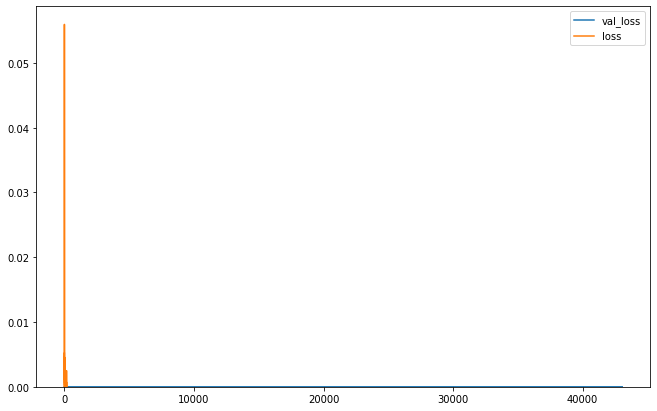

In [ ]:
plt.figure(figsize=(11,7))
sns.kdeplot(df['val_loss'])
sns.kdeplot(df['loss'])

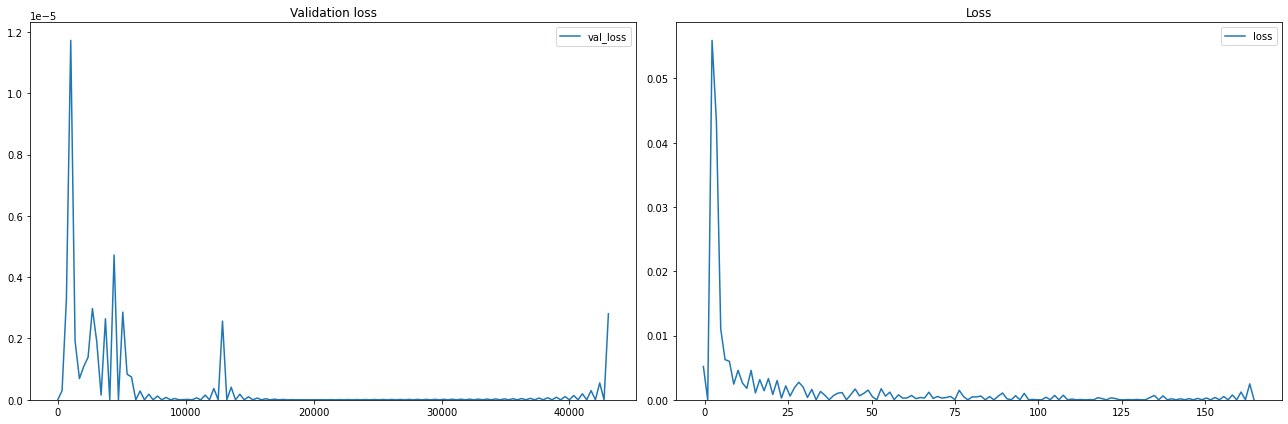

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Validation loss')
sns.kdeplot(df['val_loss'])
plt.subplot(1,2,2)
plt.title('Loss')
sns.kdeplot(df['loss'])
plt.tight_layout()

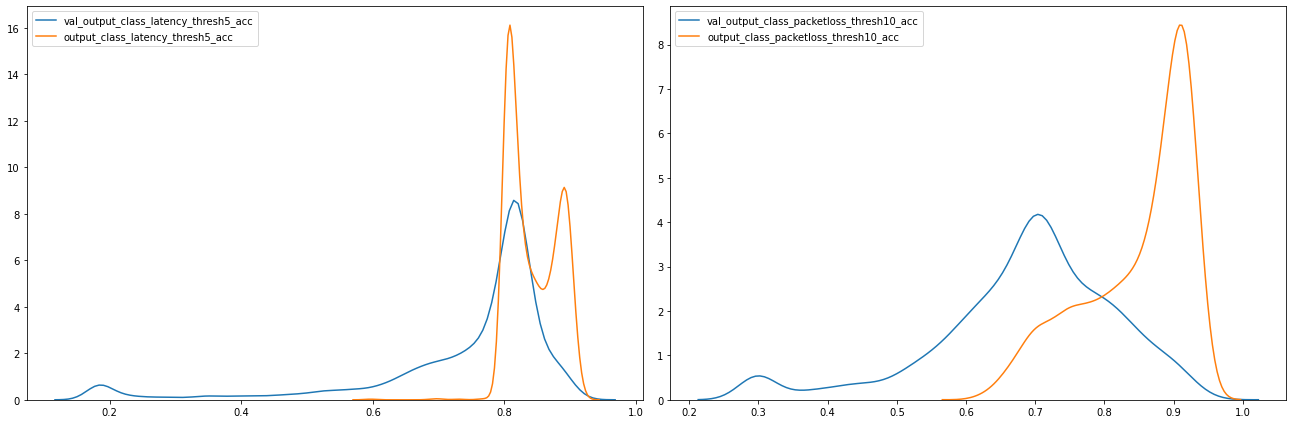

In [ ]:
plot_cols(acc_cols, df)

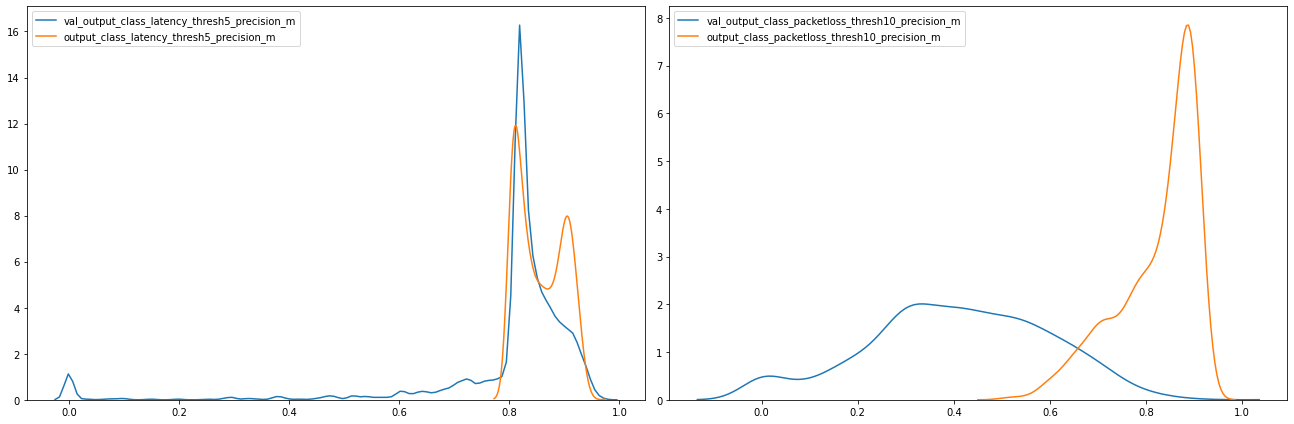

In [ ]:
plot_cols(prec_cols, df)

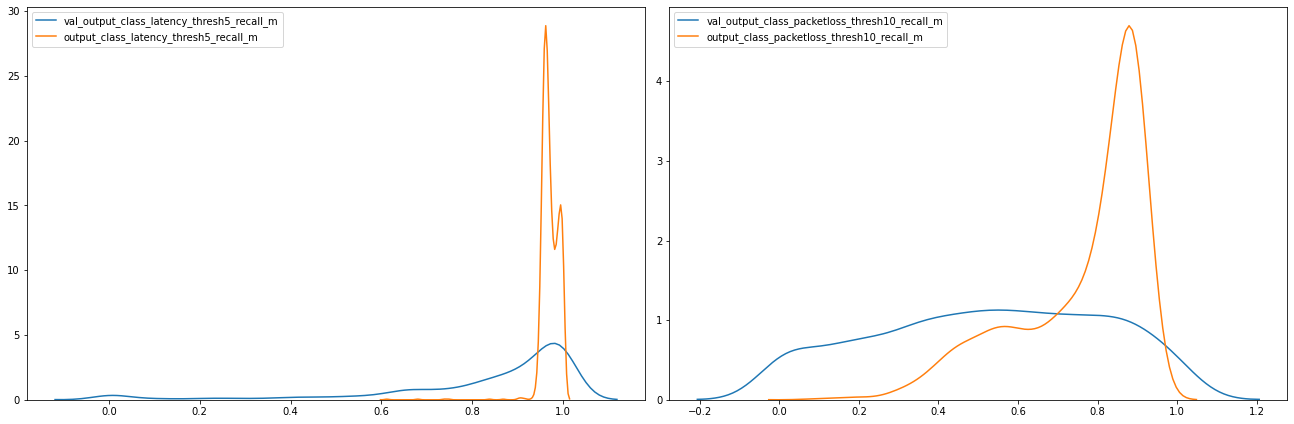

In [ ]:
plot_cols(rec_cols, df)

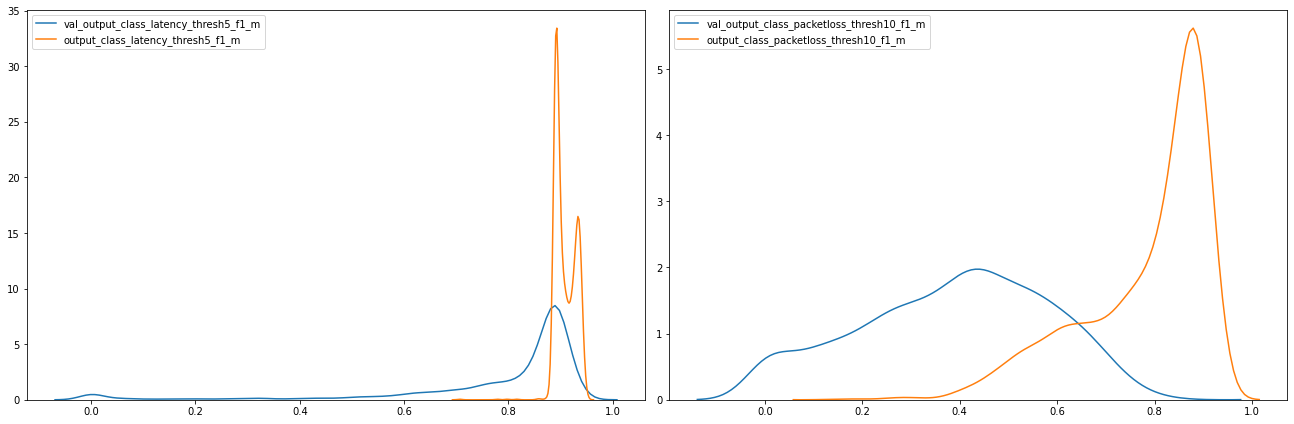

In [ ]:
plot_cols(f1_cols, df)

In [ ]:
df[df['val_loss'] == min(df['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
23,23,30,0.426857,0.287271,0.184574,0.035964,0.875,0.912347,0.917951,0.919914,0.928241,0.681654,0.737939,0.686288,0.36717,0.204894,0.145539,0.035289,0.907963,0.942931,0.932963,0.954457,0.936296,0.915437,0.922506,0.913851,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
23,23,30,0.426857,0.287271,0.184574,0.035964,0.875000,0.912347,0.917951,0.919914,0.928241,0.681654,0.737939,0.686288,0.367170,0.204894,0.145539,0.035289,0.907963,0.942931,0.932963,0.954457,0.936296,0.915437,0.922506,0.913851,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
147,147,22,0.451471,0.264905,0.190058,0.095006,0.892747,0.928507,0.881186,0.988273,0.922068,0.728432,0.709115,0.811318,0.437642,0.210377,0.162468,0.120137,0.910185,0.943967,0.942886,0.946598,0.931296,0.908413,0.911037,0.913031,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
167,167,30,0.515230,0.312771,0.144859,0.100863,0.846451,0.886596,0.939636,0.863588,0.935957,0.748181,0.737139,0.799600,0.402540,0.198761,0.143384,0.043463,0.911481,0.945162,0.936733,0.955903,0.940926,0.920890,0.925214,0.921531,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
158,158,24,0.540068,0.324850,0.192862,0.083198,0.880401,0.916002,0.912339,0.934378,0.922840,0.735754,0.712405,0.816649,0.440486,0.231820,0.168252,0.040411,0.895741,0.934954,0.928850,0.943763,0.934074,0.913226,0.910534,0.923421,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
766,766,22,0.546237,0.380429,0.251540,0.027410,0.880401,0.919770,0.897319,0.959424,0.895062,0.726294,0.654544,0.859120,0.517625,0.229666,0.184610,0.105042,0.902963,0.940275,0.927048,0.955857,0.922778,0.896912,0.909831,0.894629,64,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
478,478,23,0.610683,0.310862,0.292212,0.114644,0.895062,0.929884,0.888387,0.984520,0.884259,0.598425,0.667768,0.696079,0.514740,0.215516,0.173624,0.124061,0.909074,0.943524,0.935460,0.953919,0.926481,0.901272,0.905568,0.905976,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
618,618,18,0.615304,0.322545,0.303094,0.096151,0.886574,0.923124,0.906530,0.957446,0.889660,0.653930,0.676547,0.721120,0.577299,0.238201,0.181453,0.158787,0.898148,0.936692,0.923953,0.952400,0.921296,0.895445,0.895010,0.905395,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
585,585,15,0.621964,0.305378,0.231008,0.172551,0.885802,0.916728,0.915258,0.933398,0.912037,0.579440,0.709111,0.558300,0.623056,0.256758,0.188539,0.220147,0.892222,0.934074,0.913632,0.957505,0.921667,0.896086,0.908681,0.895222,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
473,473,16,0.625559,0.251989,0.492123,0.056198,0.89

#### Check other metrics

Accuracy

In [ ]:
print(acc_cols)

['val_output_class_latency_thresh5_acc', 'val_output_class_packetloss_thresh10_acc', 'output_class_latency_thresh5_acc', 'output_class_packetloss_thresh10_acc']


In [ ]:
df[df['val_output_class_latency_thresh5_acc'] == min(df['val_output_class_latency_thresh5_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
1500,1500,6,88.120932,2.011247,8.953023e-08,80.925697,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.67137,0.003421,0.002724,0.381665,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[40, 20, 10, 5]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>


In [ ]:
df[df['val_output_class_packetloss_thresh10_acc'] == min(df['val_output_class_packetloss_thresh10_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
708,708,12,3457.260567,1.549149e-10,110.366165,3402.38916,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.105864,0.014301,0.007192,1.797127,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.0002,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>


In [ ]:
df.sort_values('val_output_class_latency_thresh5_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,9,5.601003,0.000128,0.000061,5.740843,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,0.281433,0.000108,0.000093,0.204332,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,64,"[20, 10, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>
1123,1123,30,9.652034,0.005797,0.006754,8.774160,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,1.482952,0.001099,0.001180,1.185185,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
1136,1136,17,53.409353,0.039795,0.566192,49.965237,1.0,1.0,1.0,1.0,0.899691,0.947259,1.0,0.90767,21.741437,0.033892,0.418513,21.201130,0.999815,0.999909,1.0,0.999818,0.995926,0.997987,1.0,0.996003,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>
1135,1135,30,19.200150,0.044336,0.022523,17.546350,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,1.589416,0.017917,0.007551,1.276021,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
1134,1134,30,9.577791,0.030171,0.018524,10.810043,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,1.443010,0.011171,0.010698,1.248268,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1133,1133,17,56.842299,0.092804,0.180926,60.865395,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,5.754314,0.032360,0.066043,5.427582,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
1132,1132,17,17.959348,0.034154,0.164925,16.129747,1.0,1.0,1.0,1.0,0.999228,0.999644,1.0,0.99929,2.555951,0.041271,0.239639,2.091817,1.000000,1.000000,1.0,1.000000,0.997407,0.998723,1.0,0.997456,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>
1131,1131,30,23.822121,0.087512,0.066947,21.684988,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,3.907746,0.022027,0.030094,3.754996,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1130,1130,30,45.822737,0.055102,0.046879,44.822975,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,1.793247,0.018720,0.006805,1.539155,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_r

In [ ]:
df.sort_values('val_output_class_packetloss_thresh10_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,9,5.601003,0.000128,0.000061,5.740843,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.281433,0.000108,0.000093,0.204332,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,64,"[20, 10, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>
1127,1127,30,32.533177,0.002590,0.024928,29.791206,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.637345,0.001579,0.001714,1.566280,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1141,1141,27,50.111567,0.045848,0.030769,54.497570,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.338174,0.013056,0.014257,11.267585,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
1139,1139,30,19.812792,0.016375,0.039744,18.273411,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.018462,0.004352,0.019330,3.678805,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1138,1138,30,9.605346,0.025264,0.022421,8.623168,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.620482,0.014519,0.011798,1.319477,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1137,1137,11,83.036884,0.174368,0.162157,79.728195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,66.201084,0.116451,0.078190,65.846542,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
1135,1135,30,19.200150,0.044336,0.022523,17.546350,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.589416,0.017917,0.007551,1.276021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
1134,1134,30,9.577791,0.030171,0.018524,10.810043,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.443010,0.011171,0.010698,1.248268,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1133,1133,17,56.842299,0.092804,0.180926,60.865395,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.754314,0.032360,0.066043,5.427582,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
1131,1131,30,23.822121,0.087512,0.066947,21.684988,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.907746,0.022027,0.030094,3.754996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."


F1-score

In [ ]:
print(f1_cols)

['val_output_class_latency_thresh5_f1_m', 'val_output_class_packetloss_thresh10_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_packetloss_thresh10_f1_m']


In [ ]:
df[df['val_output_class_latency_thresh5_f1_m'] == min(df['val_output_class_latency_thresh5_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
1500,1500,6,88.120932,2.011247,8.953023e-08,80.925697,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.67137,0.003421,0.002724,0.381665,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[40, 20, 10, 5]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>


In [ ]:
df[df['val_output_class_packetloss_thresh10_f1_m'] == min(df['val_output_class_packetloss_thresh10_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
708,708,12,3457.260567,1.549149e-10,110.366165,3402.38916,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.105864,0.014301,0.007192,1.797127,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.0002,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>


In [ ]:
df.sort_values('val_output_class_latency_thresh5_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,9,5.601003,0.000128,0.000061,5.740843,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,0.281433,0.000108,0.000093,0.204332,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,64,"[20, 10, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>
1123,1123,30,9.652034,0.005797,0.006754,8.774160,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,1.482952,0.001099,0.001180,1.185185,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
1136,1136,17,53.409353,0.039795,0.566192,49.965237,1.0,1.0,1.0,1.0,0.899691,0.947259,1.0,0.90767,21.741437,0.033892,0.418513,21.201130,0.999815,0.999909,1.0,0.999818,0.995926,0.997987,1.0,0.996003,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>
1135,1135,30,19.200150,0.044336,0.022523,17.546350,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,1.589416,0.017917,0.007551,1.276021,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
1134,1134,30,9.577791,0.030171,0.018524,10.810043,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,1.443010,0.011171,0.010698,1.248268,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1133,1133,17,56.842299,0.092804,0.180926,60.865395,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,5.754314,0.032360,0.066043,5.427582,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
1132,1132,17,17.959348,0.034154,0.164925,16.129747,1.0,1.0,1.0,1.0,0.999228,0.999644,1.0,0.99929,2.555951,0.041271,0.239639,2.091817,1.000000,1.000000,1.0,1.000000,0.997407,0.998723,1.0,0.997456,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>
1131,1131,30,23.822121,0.087512,0.066947,21.684988,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,3.907746,0.022027,0.030094,3.754996,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1130,1130,30,45.822737,0.055102,0.046879,44.822975,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.00000,1.793247,0.018720,0.006805,1.539155,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_r

In [ ]:
df.sort_values('val_output_class_packetloss_thresh10_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,9,5.601003,0.000128,0.000061,5.740843,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.281433,0.000108,0.000093,0.204332,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,64,"[20, 10, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7fe55f12e0d0>
1127,1127,30,32.533177,0.002590,0.024928,29.791206,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.637345,0.001579,0.001714,1.566280,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1141,1141,27,50.111567,0.045848,0.030769,54.497570,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.338174,0.013056,0.014257,11.267585,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
1139,1139,30,19.812792,0.016375,0.039744,18.273411,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.018462,0.004352,0.019330,3.678805,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1138,1138,30,9.605346,0.025264,0.022421,8.623168,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.620482,0.014519,0.011798,1.319477,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1137,1137,11,83.036884,0.174368,0.162157,79.728195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,66.201084,0.116451,0.078190,65.846542,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
1135,1135,30,19.200150,0.044336,0.022523,17.546350,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.589416,0.017917,0.007551,1.276021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
1134,1134,30,9.577791,0.030171,0.018524,10.810043,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.443010,0.011171,0.010698,1.248268,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1133,1133,17,56.842299,0.092804,0.180926,60.865395,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.754314,0.032360,0.066043,5.427582,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
1131,1131,30,23.822121,0.087512,0.066947,21.684988,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.907746,0.022027,0.030094,3.754996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."


### Setup 2

**T1**: PL < 10%  
**T2**: LA < 5%  
**11**: EC == 12.9 +/- 0.1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

# y_train and y_val are dictionaries of {quality: data}
def build_dlaser_pipeline_setup2(x_train, y_train, x_val, y_val, params):
    callback=early_stopper(params['epochs'], monitor='val_loss', mode='moderate')

    dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_params'])
    dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_params'])
    dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_params'])
    dlaser.add_setpoint_goal('energyconsumption', 12.9, 0.1, params['class_params'])

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    dlaser.compile(params['optimizer'], params['lr'], extensive_metrics=True)

    out = dlaser.fit_gridsearch(x_train, x_val,
                                y_train, y_val,
                                batch_size=params['batch_size'], epochs=params['epochs'],
                                callback=callback,
                                verbose=False)
    model = dlaser.get_model()

    return out, model

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'core_params' : [[50,25,15],[50,80,35,15]],
    'class_params' : [[20,10,5],[30,10,4],[30,40,15,5],[40,20,10,5]],
    #'regr_params' : [[20,10,5],[30,40,15,5],[40,20,10,5]],
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4], 
    'batch_size' : [64, 128]
}

In [ ]:
import talos
t = talos.Scan(X[:25*nb_opts], {'packetloss': y_pl[:25*nb_opts], 'latency': y_la[:25*nb_opts], 'energyconsumption' : y_ec[:25*nb_opts]},  # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val={'packetloss': y_pl[25*nb_opts:], 'latency': y_la[25*nb_opts:], 'energyconsumption' : y_ec[25*nb_opts:]}, # Last 5 cycles -> test cycles
               model=build_dlaser_pipeline_setup2,
               params=p, experiment_name='setup2_deltaIoTv1')

  0%|          | 0/768 [00:00<?, ?it/s]







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 768/768 [1:53:22<00:00,  8.86s/it]


In [ ]:
t.data.to_csv('gridsearch_setup2_v1.csv')

#### Evaluation

In [ ]:
df = pd.read_csv('gridsearch_setup2_v1.csv')
df.head()

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
0,0,4,5.261525,1.872857,2.405020,0.838407,0.249228,0.124084,0.444444,0.080023,0.601080,0.516650,0.385511,0.887909,0.692901,0.297831,0.330810,0.352000,0.934323,0.222142,0.188612,0.371963,0.895926,0.935601,0.923317,0.950553,0.915741,0.888808,0.896641,0.891491,0.831296,0.772786,0.742430,0.817681,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
1,1,11,3.052083,0.913952,1.378905,0.645945,0.621914,0.637892,0.977678,0.511746,0.712191,0.033717,0.148148,0.019753,0.731481,0.380975,0.496203,0.344087,0.860872,0.208692,0.180739,0.357458,0.904815,0.940592,0.936727,0.946319,0.920556,0.893477,0.907248,0.894188,0.837593,0.778192,0.761767,0.807643,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
2,2,13,1.437332,0.307159,0.222090,0.760653,0.881173,0.917290,0.896364,0.949592,0.918981,0.741756,0.691168,0.863444,0.627315,0.411832,0.399520,0.519598,0.851054,0.210548,0.153962,0.338464,0.907222,0.942637,0.934129,0.953404,0.934630,0.912505,0.917424,0.915079,0.844444,0.784105,0.775539,0.803219,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,11,1.323096,0.362621,0.182112,0.613039,0.888117,0.924119,0.905640,0.955998,0.927469,0.734998,0.711483,0.819689,0.725309,0.442787,0.482613,0.495326,0.842961,0.197007,0.146334,0.332580,0.911667,0.944763,0.940472,0.951094,0.937407,0.916950,0.925768,0.914666,0.855556,0.799599,0.790123,0.816121,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
4,4,9,5.897518,3.065408,1.677036,1.012852,0.196759,0.029630,0.197531,0.016302,0.628858,0.519281,0.384109,0.901235,0.591049,0.504381,0.393905,0.802469,0.849772,0.207455,0.165158,0.333947,0.904815,0.940727,0.933317,0.950381,0.927222,0.903210,0.913737,0.900967,0.845926,0.786398,0.777458,0.805451,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_cols = []
acc_cols = []
prec_cols = []
rec_cols = []
f1_cols = []
for col in df.columns:
    if '_loss' in col and col != 'val_loss':
        loss_cols.append(col)
    elif '_acc' in col:
        acc_cols.append(col)
    elif '_precision' in col:
        prec_cols.append(col)
    elif '_recall' in col:
        rec_cols.append(col)
    elif '_f1' in col:
        f1_cols.append(col)
    
print(loss_cols)
print(acc_cols)
print(prec_cols)
print(rec_cols)
print(f1_cols)

['val_output_class_latency_thresh5_loss', 'val_output_class_packetloss_thresh10_loss', 'val_output_class_energyconsumption_setpoint12.9_loss', 'output_class_latency_thresh5_loss', 'output_class_packetloss_thresh10_loss', 'output_class_energyconsumption_setpoint12.9_loss']
['val_output_class_latency_thresh5_acc', 'val_output_class_packetloss_thresh10_acc', 'val_output_class_energyconsumption_setpoint12.9_acc', 'output_class_latency_thresh5_acc', 'output_class_packetloss_thresh10_acc', 'output_class_energyconsumption_setpoint12.9_acc']
['val_output_class_latency_thresh5_precision_m', 'val_output_class_packetloss_thresh10_precision_m', 'val_output_class_energyconsumption_setpoint12.9_precision_m', 'output_class_latency_thresh5_precision_m', 'output_class_packetloss_thresh10_precision_m', 'output_class_energyconsumption_setpoint12.9_precision_m']
['val_output_class_latency_thresh5_recall_m', 'val_output_class_packetloss_thresh10_recall_m', 'val_output_class_energyconsumption_setpoint12.9_r

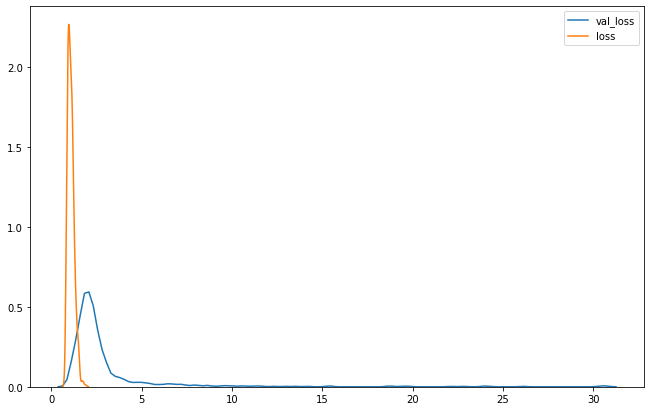

In [ ]:
plt.figure(figsize=(11,7))
sns.kdeplot(df['val_loss'])
sns.kdeplot(df['loss'])

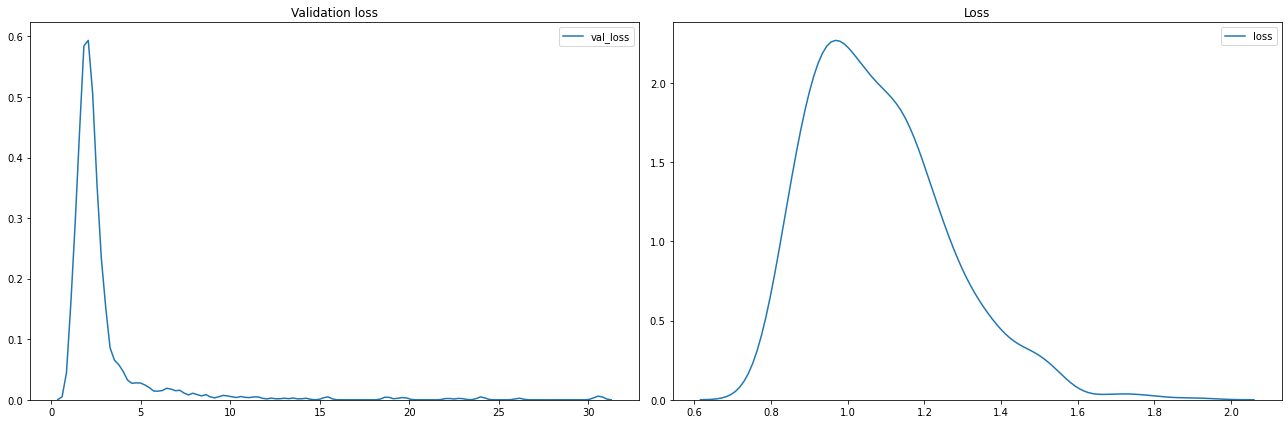

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Validation loss')
sns.kdeplot(df['val_loss'])
plt.subplot(1,2,2)
plt.title('Loss')
sns.kdeplot(df['loss'])
plt.tight_layout()

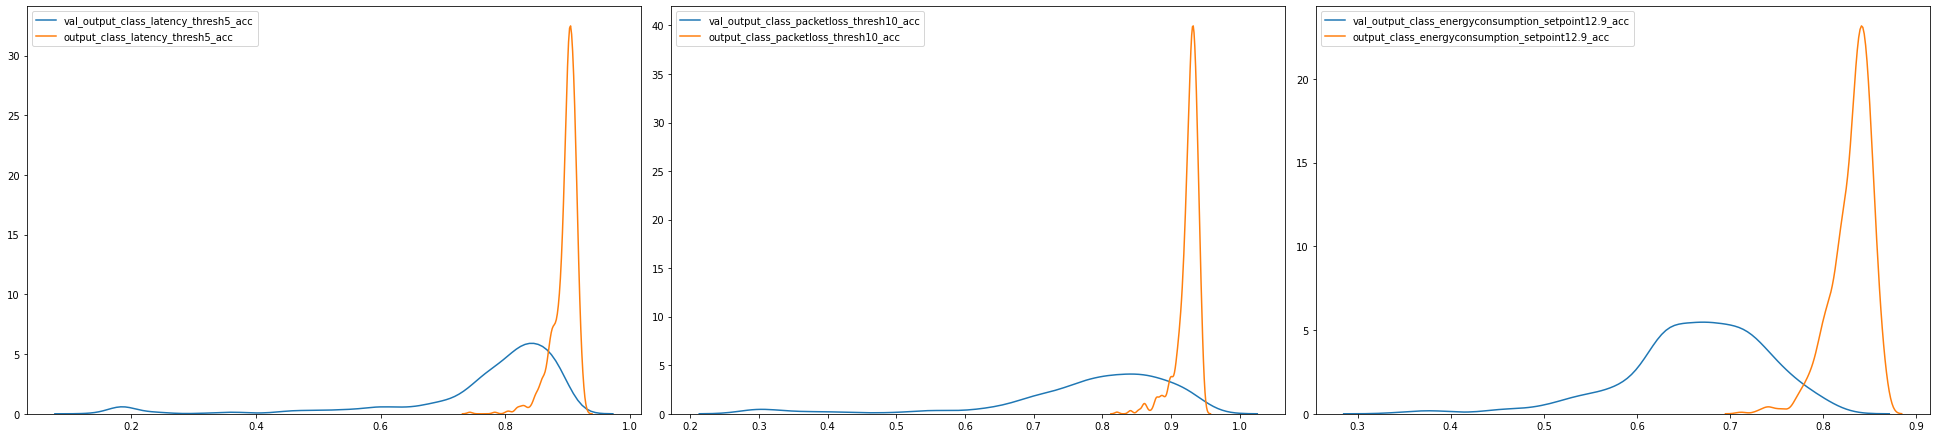

In [ ]:
plot_cols(acc_cols, df)

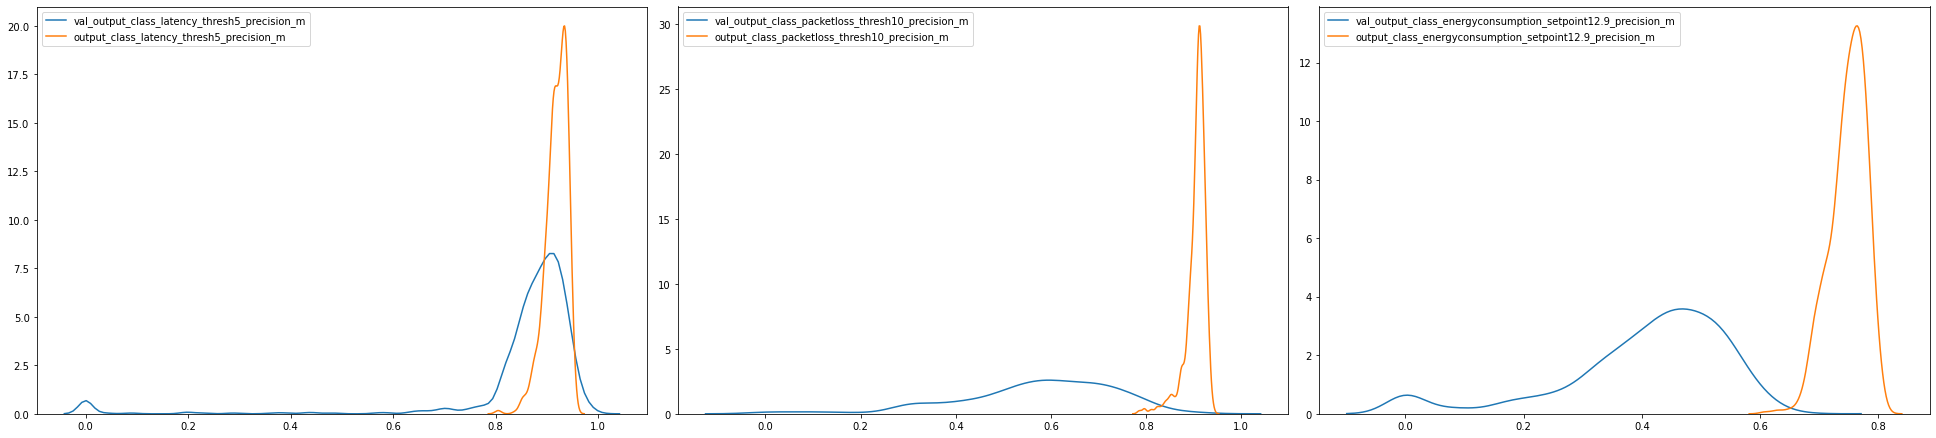

In [ ]:
plot_cols(prec_cols, df)

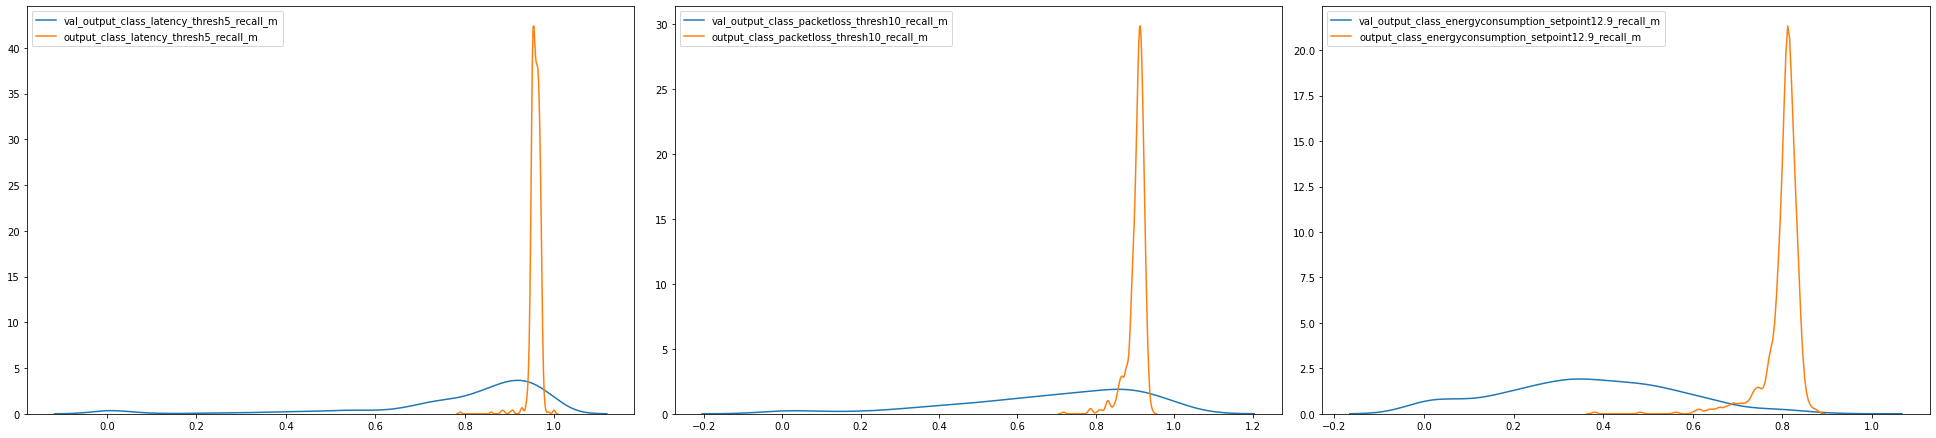

In [ ]:
plot_cols(rec_cols, df)

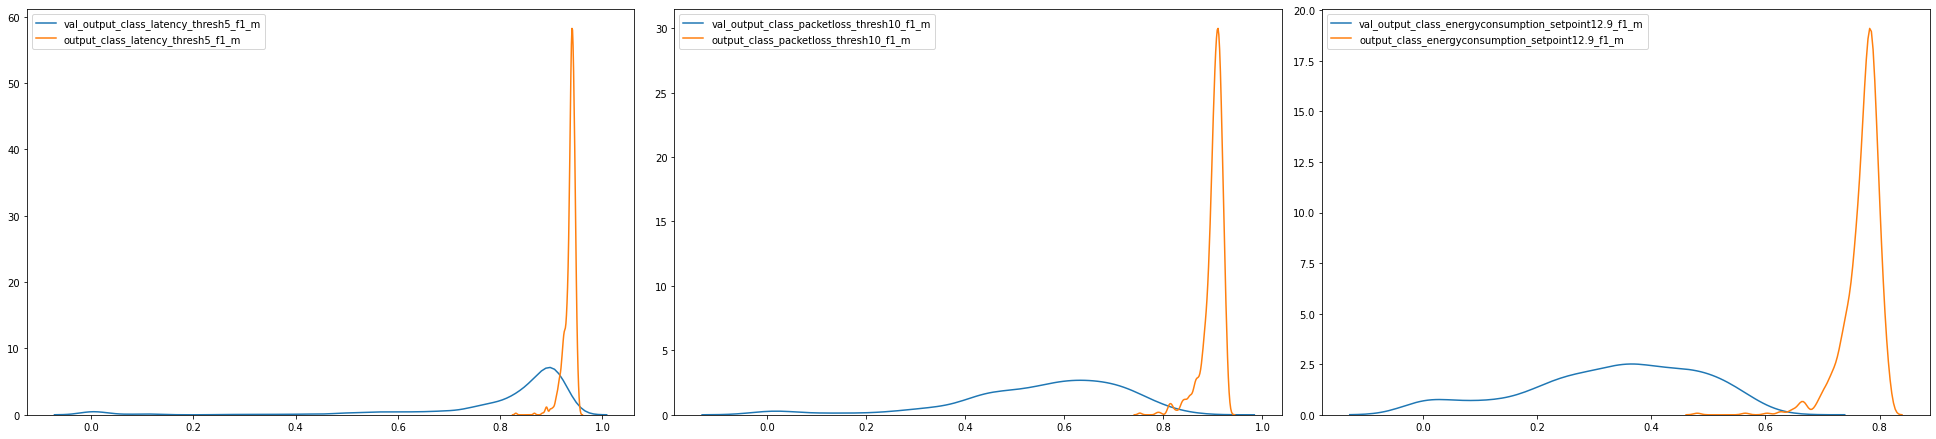

In [ ]:
plot_cols(f1_cols, df)

In [ ]:
df[df['val_loss'] == min(df['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
103,103,22,0.973931,0.251784,0.129642,0.455539,0.895833,0.91937,0.936045,0.908507,0.943673,0.752754,0.769456,0.76653,0.771605,0.561261,0.532978,0.649256,0.770018,0.186809,0.127999,0.317745,0.919815,0.9497,0.951192,0.949277,0.945556,0.928046,0.931115,0.928364,0.854259,0.800204,0.783812,0.826841,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
103,103,22,0.973931,0.251784,0.129642,0.455539,0.895833,0.919370,0.936045,0.908507,0.943673,0.752754,0.769456,0.766530,0.771605,0.561261,0.532978,0.649256,0.770018,0.186809,0.127999,0.317745,0.919815,0.949700,0.951192,0.949277,0.945556,0.928046,0.931115,0.928364,0.854259,0.800204,0.783812,0.826841,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
102,102,12,0.988406,0.244713,0.153106,0.448023,0.901235,0.929907,0.944213,0.920298,0.938272,0.732835,0.756531,0.734299,0.770062,0.531094,0.531963,0.573548,0.846886,0.203209,0.152371,0.345393,0.907037,0.941779,0.944215,0.941943,0.935185,0.914090,0.915638,0.920747,0.838704,0.772433,0.778223,0.779366,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
6,6,16,1.017155,0.249583,0.236088,0.404670,0.895833,0.920560,0.950034,0.901783,0.902006,0.711754,0.628380,0.877304,0.805556,0.524379,0.556675,0.517809,0.808221,0.201974,0.150528,0.327992,0.909630,0.943507,0.943928,0.944819,0.937593,0.916721,0.923250,0.918767,0.851667,0.795587,0.778931,0.821366,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
106,106,17,1.018569,0.283432,0.150299,0.451588,0.876543,0.919913,0.872543,0.985612,0.925926,0.678218,0.774588,0.641265,0.783179,0.568263,0.528947,0.662354,0.832120,0.202740,0.156924,0.337660,0.911481,0.944988,0.942501,0.949168,0.935556,0.914261,0.918758,0.919002,0.845370,0.786134,0.776851,0.807190,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
582,582,19,1.043520,0.280906,0.150492,0.449288,0.890432,0.927563,0.912652,0.948114,0.935185,0.815538,0.828002,0.819343,0.794753,0.610807,0.588947,0.682092,0.797859,0.185742,0.139049,0.307052,0.916481,0.947874,0.946229,0.950896,0.940000,0.920686,0.936560,0.909520,0.858148,0.806018,0.791376,0.825926,128,"[30, 40, 15, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
58,58,13,1.056306,0.301415,0.186994,0.413312,0.881944,0.910910,0.933692,0.899257,0.911265,0.726601,0.688293,0.823674,0.810957,0.528353,0.548423,0.543962,0.834982,0.197174,0.151207,0.329947,0.914074,0.946590,0.939657,0.955192,0.934074,0.912915,0.915515,0.917090,0.845556,0.784686,0.782011,0.797331,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
295,295,17,1.064680,0.243848,0.143917,0

#### Check other metrics

Accuracy

In [ ]:
print(acc_cols)

['val_output_class_latency_thresh5_acc', 'val_output_class_packetloss_thresh10_acc', 'val_output_class_energyconsumption_setpoint12.9_acc', 'output_class_latency_thresh5_acc', 'output_class_packetloss_thresh10_acc', 'output_class_energyconsumption_setpoint12.9_acc']


In [ ]:
df[df['val_output_class_latency_thresh5_acc'] == min(df['val_output_class_latency_thresh5_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
492,492,4,23.940064,6.456457,11.231016,6.031849,0.142747,0.02317,0.037816,0.016786,0.295525,0.439139,0.295525,1.0,0.625772,0.0,0.0,0.0,0.981506,0.222457,0.17302,0.354384,0.90537,0.94227,0.918676,0.968091,0.925556,0.902446,0.902868,0.904519,0.835,0.775933,0.747961,0.813732,128,"[30, 10, 4]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>


In [ ]:
df[df['val_output_class_packetloss_thresh10_acc'] == min(df['val_output_class_packetloss_thresh10_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
416,416,4,5.520458,2.062407,2.359234,0.796936,0.412037,0.423487,0.851117,0.314917,0.294753,0.433082,0.292543,0.977378,0.607253,0.055408,0.447266,0.033168,1.480653,0.329476,0.37998,0.462556,0.876296,0.925153,0.898281,0.954609,0.858148,0.815562,0.811536,0.824029,0.770185,0.659966,0.698971,0.629675,128,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fa1586d00f0>


In [ ]:
df[df['val_output_class_energyconsumption_setpoint12.9_acc'] == min(df['val_output_class_energyconsumption_setpoint12.9_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
584,584,11,4.544505,0.863072,2.174836,1.290821,0.816358,0.891819,0.817012,0.9975,0.546296,0.548661,0.412312,0.981344,0.341821,0.085795,0.137863,0.095074,0.880747,0.187028,0.153242,0.324084,0.922222,0.95161,0.945943,0.958142,0.932963,0.911949,0.911581,0.917021,0.853148,0.798778,0.781568,0.822449,128,"[30, 40, 15, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fa1586d00f0>


In [ ]:
df.sort_values('val_output_class_latency_thresh5_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
147,147,11,1.229630,0.304373,0.203774,0.533773,0.907407,0.936427,0.919229,0.959697,0.915895,0.704991,0.697888,0.752916,0.770833,0.507237,0.597472,0.488715,0.879652,0.202171,0.147903,0.340373,0.912037,0.944865,0.945019,0.946531,0.941296,0.922802,0.929717,0.922290,0.848333,0.791123,0.773713,0.818182,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
295,295,17,1.064680,0.243848,0.143917,0.512340,0.903549,0.933281,0.927474,0.942508,0.934414,0.761595,0.781074,0.763353,0.739198,0.477145,0.492660,0.510673,0.831400,0.198025,0.141406,0.325029,0.910556,0.944096,0.942079,0.948140,0.940000,0.919438,0.931456,0.914161,0.853889,0.799410,0.787214,0.820639,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
247,247,19,1.139802,0.240636,0.193272,0.539408,0.902006,0.931621,0.906405,0.964954,0.922068,0.629181,0.737419,0.561993,0.770833,0.459500,0.529319,0.446711,0.829276,0.187589,0.142287,0.331900,0.914630,0.946868,0.942744,0.952890,0.938704,0.917890,0.928685,0.914723,0.842963,0.775921,0.789712,0.777769,64,"[30, 40, 15, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
443,443,16,1.475761,0.327915,0.271412,0.682467,0.901235,0.932744,0.929546,0.938274,0.892747,0.760662,0.740618,0.824427,0.703704,0.337348,0.417812,0.324750,0.785722,0.173090,0.119973,0.297170,0.922593,0.951640,0.953579,0.950223,0.945000,0.927178,0.937810,0.919666,0.866111,0.817211,0.799568,0.840729,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
102,102,12,0.988406,0.244713,0.153106,0.448023,0.901235,0.929907,0.944213,0.920298,0.938272,0.732835,0.756531,0.734299,0.770062,0.531094,0.531963,0.573548,0.846886,0.203209,0.152371,0.345393,0.907037,0.941779,0.944215,0.941943,0.935185,0.914090,0.915638,0.920747,0.838704,0.772433,0.778223,0.779366,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
56,56,5,5.463885,0.266599,3.796004,1.179451,0.898920,0.923232,0.937245,0.916342,0.704475,0.000000,0.000000,0.000000,0.660494,0.141344,0.288360,0.100427,0.978470,0.217394,0.181734,0.351722,0.904074,0.940285,0.934105,0.948693,0.922407,0.896530,0.899944,0.904648,0.835741,0.776982,0.752963,0.814633,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
311,311,

In [ ]:
df.sort_values('val_output_class_packetloss_thresh10_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
103,103,22,0.973931,0.251784,0.129642,0.455539,0.895833,0.919370,0.936045,0.908507,0.943673,0.752754,0.769456,0.766530,0.771605,0.561261,0.532978,0.649256,0.770018,0.186809,0.127999,0.317745,0.919815,0.949700,0.951192,0.949277,0.945556,0.928046,0.931115,0.928364,0.854259,0.800204,0.783812,0.826841,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
435,435,15,1.321789,0.371635,0.148745,0.602029,0.874228,0.913941,0.925620,0.914943,0.942130,0.821873,0.837017,0.816300,0.724537,0.511641,0.544013,0.574669,0.811569,0.176722,0.131888,0.302021,0.921481,0.951305,0.946091,0.957525,0.945000,0.927095,0.938565,0.919178,0.867407,0.817257,0.803047,0.838323,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
151,151,11,1.166743,0.304909,0.148979,0.526220,0.890432,0.926492,0.896271,0.969796,0.939815,0.736079,0.734993,0.759666,0.719136,0.506160,0.529520,0.533679,0.895130,0.195187,0.165020,0.344638,0.915741,0.947290,0.948420,0.947950,0.931667,0.908597,0.911830,0.915094,0.844444,0.787448,0.763159,0.824848,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
195,195,14,1.141891,0.305056,0.162507,0.503309,0.875772,0.914069,0.895810,0.945660,0.939815,0.731074,0.753373,0.742854,0.767747,0.521782,0.551120,0.550504,0.859178,0.199639,0.149715,0.336871,0.912593,0.945848,0.937232,0.956281,0.937407,0.917158,0.920994,0.920260,0.845926,0.788440,0.775145,0.814292,64,"[30, 40, 15, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
102,102,12,0.988406,0.244713,0.153106,0.448023,0.901235,0.929907,0.944213,0.920298,0.938272,0.732835,0.756531,0.734299,0.770062,0.531094,0.531963,0.573548,0.846886,0.203209,0.152371,0.345393,0.907037,0.941779,0.944215,0.941943,0.935185,0.914090,0.915638,0.920747,0.838704,0.772433,0.778223,0.779366,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
391,391,19,1.294268,0.234350,0.174527,0.727973,0.895833,0.924285,0.930283,0.925463,0.938272,0.852940,0.811900,0.917299,0.727623,0.443139,0.553110,0.434751,0.766640,0.178857,0.129847,0.299225,0.921296,0.950878,0.952465,0.949873,0.943148,0.925486,0.933180,0.920860,0.866111,0.814985,0.804388,0.831586,128,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
339,339,

In [ ]:
df.sort_values('val_output_class_energyconsumption_setpoint12.9_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
204,204,9,1.777228,0.725765,0.409507,0.438915,0.674383,0.662410,0.936204,0.579087,0.836420,0.431904,0.612638,0.394187,0.814043,0.534485,0.553315,0.546463,0.939004,0.212928,0.172160,0.346860,0.904444,0.941044,0.930444,0.954019,0.927963,0.904672,0.909601,0.907457,0.841481,0.781176,0.771218,0.802772,64,"[30, 40, 15, 5]","[50, 25, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
58,58,13,1.056306,0.301415,0.186994,0.413312,0.881944,0.910910,0.933692,0.899257,0.911265,0.726601,0.688293,0.823674,0.810957,0.528353,0.548423,0.543962,0.834982,0.197174,0.151207,0.329947,0.914074,0.946590,0.939657,0.955192,0.934074,0.912915,0.915515,0.917090,0.845556,0.784686,0.782011,0.797331,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
144,144,14,1.466504,0.538746,0.357164,0.429340,0.802469,0.835312,0.951680,0.773845,0.865741,0.501871,0.698583,0.426940,0.809414,0.586082,0.559792,0.653669,0.917565,0.232468,0.178152,0.364692,0.896481,0.936407,0.921543,0.954170,0.923519,0.898967,0.909742,0.898247,0.827593,0.764562,0.753549,0.792301,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
98,98,12,1.464409,0.339222,0.528104,0.445226,0.886574,0.920661,0.921423,0.929043,0.847994,0.660557,0.553546,0.894688,0.808642,0.555755,0.578009,0.565507,0.858654,0.211601,0.156855,0.337421,0.908333,0.943187,0.934321,0.954238,0.937407,0.916265,0.925832,0.913442,0.845741,0.787570,0.770387,0.814266,64,"[30, 10, 4]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
32,32,16,1.422498,0.285364,0.458730,0.450024,0.895833,0.926163,0.944414,0.917068,0.820988,0.328420,0.494159,0.272191,0.806327,0.567788,0.558898,0.624504,0.938107,0.209007,0.157585,0.341692,0.911296,0.944934,0.935729,0.955722,0.937037,0.916291,0.920115,0.919843,0.847593,0.789049,0.775376,0.811771,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
6,6,16,1.017155,0.249583,0.236088,0.404670,0.895833,0.920560,0.950034,0.901783,0.902006,0.711754,0.628380,0.877304,0.805556,0.524379,0.556675,0.517809,0.808221,0.201974,0.150528,0.327992,0.909630,0.943507,0.943928,0.944819,0.937593,0.916721,0.923250,0.918767,0.851667,0.795587,0.778931,0.821366,64,"[20, 10, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
200,200,9,6.077325,0.884937,4.575401,0.

F1-score

In [ ]:
print(f1_cols)

['val_output_class_latency_thresh5_f1_m', 'val_output_class_packetloss_thresh10_f1_m', 'val_output_class_energyconsumption_setpoint12.9_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_packetloss_thresh10_f1_m', 'output_class_energyconsumption_setpoint12.9_f1_m']


In [ ]:
df[df['val_output_class_latency_thresh5_f1_m'] == min(df['val_output_class_latency_thresh5_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
16,16,12,4.737465,3.552532,0.436262,0.573043,0.18287,0.0,0.0,0.0,0.789352,0.359030,0.572038,0.344155,0.643519,0.061331,0.171193,0.041984,0.865439,0.198162,0.155645,0.335970,0.911481,0.945032,0.938322,0.953464,0.932037,0.910396,0.914839,0.913639,0.848333,0.792002,0.776119,0.818664,64,"[20, 10, 5]","[50, 25, 15]",30,0.0020,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
24,24,6,24.097437,11.507012,4.057966,8.320042,0.18287,0.0,0.0,0.0,0.704475,0.000000,0.000000,0.000000,0.374228,0.482739,0.374228,0.802469,1.114749,0.253806,0.248826,0.395831,0.897963,0.937785,0.914057,0.964420,0.906481,0.876214,0.885555,0.875880,0.813519,0.748746,0.715031,0.794873,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
72,72,5,13.530689,8.274989,1.872781,3.126952,0.18287,0.0,0.0,0.0,0.734568,0.101326,0.131852,0.085555,0.625772,0.000000,0.000000,0.000000,1.100065,0.237922,0.216627,0.385353,0.904074,0.941165,0.920664,0.964587,0.906111,0.876619,0.873433,0.888080,0.821296,0.756302,0.732182,0.792227,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
136,136,11,22.843960,5.365507,11.223972,5.978856,0.18287,0.0,0.0,0.0,0.295525,0.419072,0.295525,0.901235,0.625772,0.000000,0.000000,0.000000,1.209651,0.305723,0.229821,0.397231,0.889074,0.932193,0.912320,0.954382,0.908704,0.878043,0.887263,0.880450,0.801296,0.738609,0.698241,0.793372,64,"[30, 10, 4]","[50, 25, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
168,168,6,18.718832,13.166982,1.305636,3.946369,0.18287,0.0,0.0,0.0,0.732253,0.084355,0.192044,0.063573,0.625772,0.000000,0.000000,0.000000,1.140662,0.245259,0.224139,0.366885,0.896111,0.936518,0.916621,0.959191,0.903704,0.872702,0.878336,0.876602,0.830185,0.766555,0.748500,0.794036,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
252,252,6,3.645020,2.022513,0.584940,0.787851,0.18287,0.0,0.0,0.0,0.777006,0.629131,0.523575,0.887559,0.743827,0.463784,0.535236,0.473752,1.037691,0.221965,0.194390,0.365917,0.905000,0.941276,0.932242,0.952491,0.913704,0.885684,0.892459,0.891563,0.827407,0.761859,0.744714,0.792555,64,"[30, 40, 15, 5]","[50, 80, 35, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
292,292,9,26.104281,13.143285,7.867497,4.914013,0.18287,0.0,0.0,0.0,0.295525,0.419072,0.295525,0.901235,0.625772,0.000000,0.000000,

In [ ]:
df[df['val_output_class_packetloss_thresh10_f1_m'] == min(df['val_output_class_packetloss_thresh10_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
24,24,6,24.097437,11.507012,4.057966,8.320042,0.182870,0.000000,0.000000,0.000000,0.704475,0.0,0.0,0.0,0.374228,0.482739,0.374228,0.802469,1.114749,0.253806,0.248826,0.395831,0.897963,0.937785,0.914057,0.964420,0.906481,0.876214,0.885555,0.875880,0.813519,0.748746,0.715031,0.794873,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
56,56,5,5.463885,0.266599,3.796004,1.179451,0.898920,0.923232,0.937245,0.916342,0.704475,0.0,0.0,0.0,0.660494,0.141344,0.288360,0.100427,0.978470,0.217394,0.181734,0.351722,0.904074,0.940285,0.934105,0.948693,0.922407,0.896530,0.899944,0.904648,0.835741,0.776982,0.752963,0.814633,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
196,196,6,4.198246,0.359002,2.322858,1.288157,0.832562,0.864343,0.950907,0.819388,0.704475,0.0,0.0,0.0,0.629630,0.130776,0.265788,0.106993,0.985588,0.215401,0.176969,0.355496,0.904074,0.940961,0.923674,0.961235,0.923704,0.900015,0.909345,0.899189,0.836111,0.771846,0.760909,0.796573,64,"[30, 40, 15, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
460,460,10,22.147196,12.656913,4.763295,4.462973,0.182870,0.000000,0.000000,0.000000,0.704475,0.0,0.0,0.0,0.374228,0.488896,0.374228,0.901235,1.048109,0.236701,0.176528,0.371100,0.908148,0.943343,0.932913,0.954735,0.930741,0.908893,0.908248,0.913331,0.817407,0.768185,0.702491,0.852867,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
493,493,5,3.099117,0.405539,1.660679,0.795633,0.890432,0.928564,0.919909,0.946180,0.704475,0.0,0.0,0.0,0.641204,0.559401,0.443446,0.865178,0.969041,0.212142,0.153783,0.359714,0.903519,0.941230,0.916274,0.968603,0.933889,0.912674,0.915304,0.914144,0.834444,0.778170,0.747250,0.818202,128,"[30, 10, 4]","[50, 25, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
588,588,4,19.773361,8.925337,4.536607,6.031849,0.182870,0.000000,0.000000,0.000000,0.704475,0.0,0.0,0.0,0.625772,0.000000,0.000000,0.000000,1.026059,0.207266,0.179382,0.349010,0.907593,0.942903,0.932626,0.954116,0.925926,0.903634,0.905257,0.905199,0.842778,0.786325,0.764869,0.814892,128,"[30, 40, 15, 5]","[50, 25, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
604,604,10,19.475184,12.870693,4.763295,1.513463,0.182870,0.000000,0.000000,0.000000,0.704475,0.0,0.0,0.0,0.667438,0.493020,0.433853,0.687678,1.14

In [ ]:
df[df['val_output_class_energyconsumption_setpoint12.9_f1_m'] == min(df['val_output_class_energyconsumption_setpoint12.9_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
8,8,4,15.314486,1.168046,11.231016,2.720942,0.817130,0.889690,0.817130,1.000000,0.295525,0.419072,0.295525,0.901235,0.625772,0.0,0.0,0.0,0.965013,0.223147,0.189701,0.359214,0.902963,0.940235,0.926009,0.956480,0.920926,0.895797,0.893687,0.909188,0.835556,0.772744,0.757811,0.800442,64,"[20, 10, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
33,33,6,2.421614,0.643526,0.341044,1.176833,0.648148,0.665899,0.834369,0.598367,0.847994,0.669241,0.595775,0.859386,0.625772,0.0,0.0,0.0,1.125603,0.283022,0.173573,0.407221,0.892593,0.934564,0.906747,0.966029,0.929259,0.906217,0.909330,0.910153,0.801111,0.731414,0.705686,0.771752,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
52,52,4,14.183409,0.387655,11.230168,2.345762,0.841821,0.867720,0.920812,0.854405,0.295525,0.419072,0.295525,0.901235,0.625772,0.0,0.0,0.0,1.008363,0.227504,0.186565,0.367400,0.893333,0.933883,0.922763,0.947542,0.924074,0.899965,0.904635,0.904741,0.832778,0.770558,0.749863,0.807486,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
60,60,8,8.602659,4.893765,0.885489,2.652319,0.207562,0.059072,0.288066,0.034630,0.728395,0.064871,0.148148,0.041644,0.625772,0.0,0.0,0.0,0.899005,0.208378,0.173406,0.343398,0.907593,0.942830,0.929974,0.957644,0.924815,0.900466,0.906163,0.903362,0.838333,0.773206,0.769030,0.789821,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
72,72,5,13.530689,8.274989,1.872781,3.126952,0.182870,0.000000,0.000000,0.000000,0.734568,0.101326,0.131852,0.085555,0.625772,0.0,0.0,0.0,1.100065,0.237922,0.216627,0.385353,0.904074,0.941165,0.920664,0.964587,0.906111,0.876619,0.873433,0.888080,0.821296,0.756302,0.732182,0.792227,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
136,136,11,22.843960,5.365507,11.223972,5.978856,0.182870,0.000000,0.000000,0.000000,0.295525,0.419072,0.295525,0.901235,0.625772,0.0,0.0,0.0,1.209651,0.305723,0.229821,0.397231,0.889074,0.932193,0.912320,0.954382,0.908704,0.878043,0.887263,0.880450,0.801296,0.738609,0.698241,0.793372,64,"[30, 10, 4]","[50, 25, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
156,156,5,8.056390,1.811718,4.251210,1.789402,0.519290,0.543181,0.914770,0.412853,0.391975,0.460956,0.337497,0.901235,0.625772,0.0,0.0,0.0,0.987376,0.219839,0.19

In [ ]:
df.sort_values('val_output_class_latency_thresh5_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
147,147,11,1.229630,0.304373,0.203774,0.533773,0.907407,0.936427,0.919229,0.959697,0.915895,0.704991,0.697888,0.752916,0.770833,0.507237,0.597472,0.488715,0.879652,0.202171,0.147903,0.340373,0.912037,0.944865,0.945019,0.946531,0.941296,0.922802,0.929717,0.922290,0.848333,0.791123,0.773713,0.818182,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
484,484,7,10.185249,0.298224,8.447940,1.244288,0.896605,0.933373,0.890233,0.986050,0.295525,0.439139,0.295525,1.000000,0.625772,0.000000,0.000000,0.000000,0.888323,0.197903,0.161117,0.330104,0.914630,0.947215,0.940028,0.955259,0.932222,0.910461,0.914675,0.910520,0.849630,0.793127,0.784027,0.807528,128,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
295,295,17,1.064680,0.243848,0.143917,0.512340,0.903549,0.933281,0.927474,0.942508,0.934414,0.761595,0.781074,0.763353,0.739198,0.477145,0.492660,0.510673,0.831400,0.198025,0.141406,0.325029,0.910556,0.944096,0.942079,0.948140,0.940000,0.919438,0.931456,0.914161,0.853889,0.799410,0.787214,0.820639,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
443,443,16,1.475761,0.327915,0.271412,0.682467,0.901235,0.932744,0.929546,0.938274,0.892747,0.760662,0.740618,0.824427,0.703704,0.337348,0.417812,0.324750,0.785722,0.173090,0.119973,0.297170,0.922593,0.951640,0.953579,0.950223,0.945000,0.927178,0.937810,0.919666,0.866111,0.817211,0.799568,0.840729,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
530,530,4,2.416191,0.420539,0.444232,1.285027,0.896605,0.932226,0.897514,0.973912,0.870370,0.772741,0.664966,0.990711,0.650463,0.134321,0.372957,0.089451,1.052899,0.233482,0.175770,0.371719,0.900185,0.938544,0.926774,0.951636,0.921852,0.896732,0.902032,0.896653,0.825741,0.762225,0.744612,0.789296,128,"[30, 10, 4]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
247,247,19,1.139802,0.240636,0.193272,0.539408,0.902006,0.931621,0.906405,0.964954,0.922068,0.629181,0.737419,0.561993,0.770833,0.459500,0.529319,0.446711,0.829276,0.187589,0.142287,0.331900,0.914630,0.946868,0.942744,0.952890,0.938704,0.917890,0.928685,0.914723,0.842963,0.775921,0.789712,0.777769,64,"[30, 40, 15, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
67

In [ ]:
df.sort_values('val_output_class_packetloss_thresh10_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
391,391,19,1.294268,0.234350,0.174527,0.727973,0.895833,0.924285,0.930283,0.925463,0.938272,0.852940,0.811900,0.917299,0.727623,0.443139,0.553110,0.434751,0.766640,0.178857,0.129847,0.299225,0.921296,0.950878,0.952465,0.949873,0.943148,0.925486,0.933180,0.920860,0.866111,0.814985,0.804388,0.831586,128,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
630,630,4,2.127386,0.717419,0.194796,0.883515,0.732253,0.792998,0.923777,0.705622,0.937500,0.841315,0.800282,0.889741,0.662037,0.306420,0.420306,0.305145,1.110312,0.239529,0.164526,0.368024,0.901111,0.939816,0.917436,0.964207,0.929815,0.907914,0.910956,0.909762,0.823148,0.765246,0.728122,0.813083,128,"[30, 40, 15, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
439,439,18,1.387846,0.291822,0.267112,0.642074,0.875000,0.915445,0.926620,0.916568,0.921296,0.831139,0.774775,0.953996,0.705247,0.502394,0.569274,0.533883,0.807268,0.180810,0.137504,0.299601,0.920926,0.950404,0.950114,0.951513,0.941481,0.922072,0.929344,0.919086,0.861111,0.810113,0.795410,0.832799,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
583,583,10,1.586359,0.468903,0.218049,0.655549,0.822531,0.868331,0.927897,0.824190,0.920525,0.830950,0.777586,0.953750,0.730710,0.409497,0.627036,0.312782,0.914644,0.200067,0.139181,0.326967,0.911667,0.945654,0.932789,0.959799,0.940185,0.921196,0.920109,0.925131,0.847963,0.796030,0.767137,0.830931,128,"[30, 40, 15, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
450,450,7,1.735084,0.363965,0.265926,0.840916,0.837963,0.886263,0.933272,0.848965,0.915123,0.827177,0.786526,0.942134,0.648148,0.303215,0.380131,0.298493,0.959029,0.211372,0.142891,0.338479,0.912037,0.945916,0.931355,0.961581,0.941296,0.922328,0.935644,0.912544,0.840741,0.784870,0.763340,0.814152,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.002,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
486,486,22,1.149990,0.338494,0.178616,0.491941,0.890432,0.927646,0.918129,0.947753,0.925926,0.826324,0.804546,0.898761,0.765432,0.563886,0.547784,0.685461,0.777689,0.177689,0.140952,0.317102,0.920185,0.950349,0.948032,0.953631,0.941296,0.923023,0.919319,0.930608,0.851667,0.791135,0.793365,0.797128,128,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
387,387,12,1

In [ ]:
df.sort_values('val_output_class_energyconsumption_setpoint12.9_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
582,582,19,1.043520,0.280906,0.150492,0.449288,0.890432,0.927563,0.912652,0.948114,0.935185,0.815538,0.828002,0.819343,0.794753,0.610807,0.588947,0.682092,0.797859,0.185742,0.139049,0.307052,0.916481,0.947874,0.946229,0.950896,0.940000,0.920686,0.936560,0.909520,0.858148,0.806018,0.791376,0.825926,128,"[30, 40, 15, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
724,724,12,2.835535,0.700378,1.500602,0.426179,0.743827,0.785868,0.931525,0.695368,0.734568,0.129343,0.291358,0.093725,0.785494,0.605499,0.637723,0.604528,0.891110,0.194319,0.155599,0.325712,0.912593,0.946278,0.933720,0.960449,0.933704,0.912074,0.921892,0.909674,0.852963,0.796588,0.789372,0.808953,128,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
144,144,14,1.466504,0.538746,0.357164,0.429340,0.802469,0.835312,0.951680,0.773845,0.865741,0.501871,0.698583,0.426940,0.809414,0.586082,0.559792,0.653669,0.917565,0.232468,0.178152,0.364692,0.896481,0.936407,0.921543,0.954170,0.923519,0.898967,0.909742,0.898247,0.827593,0.764562,0.753549,0.792301,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fa1586d00f0>
476,476,18,1.711697,0.321445,0.549881,0.532464,0.871914,0.918599,0.897399,0.953350,0.787809,0.594030,0.663891,0.727107,0.757716,0.585230,0.566604,0.645528,1.068752,0.222568,0.176673,0.360327,0.908889,0.943427,0.938261,0.949412,0.929630,0.906027,0.916014,0.900057,0.821481,0.772538,0.710212,0.851414,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0002,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fa1586d00f0>
550,550,7,1.526913,0.328425,0.430218,0.485277,0.889660,0.924564,0.919321,0.937185,0.821759,0.703878,0.642183,0.895563,0.750772,0.584849,0.518822,0.705496,0.967764,0.209682,0.141009,0.331619,0.910185,0.945112,0.924922,0.967045,0.941667,0.922700,0.929473,0.918860,0.843889,0.788350,0.769314,0.814285,128,"[30, 10, 4]","[50, 80, 35, 15]",30,0.0020,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
529,529,8,2.246792,0.289956,1.063321,0.713490,0.883488,0.921391,0.908036,0.939519,0.766975,0.681662,0.545142,1.000000,0.702932,0.575174,0.508427,0.770490,0.882447,0.202569,0.151658,0.342877,0.911667,0.945382,0.936806,0.955431,0.936111,0.916224,0.923633,0.912283,0.842963,0.789223,0.761494,0.824525,128,"[30, 10, 4]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
760,760,10,2.176227,0.366099,0.77582

### Setup 3

**T1**: LA < 5%  
**S1**: minimize PL  
**O1**: EC == 12.9 +/- 0.1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

# y_train and y_val are dictionaries of {quality: data}
def build_dlaser_pipeline_setup3(x_train, y_train, x_val, y_val, params):
    callback=early_stopper(params['epochs'], monitor='val_loss', mode='moderate')

    dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_params'])
    dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_params'])
    dlaser.add_optimizataion_goal('packetloss', Operator.Min, params['regr_params'])
    dlaser.add_setpoint_goal('energyconsumption', 12.9, 0.1, params['class_params'])

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    dlaser.compile(params['optimizer'], params['lr'], extensive_metrics=True)

    out = dlaser.fit_gridsearch(x_train, x_val,
                                y_train, y_val,
                                batch_size=params['batch_size'], epochs=params['epochs'],
                                callback=callback,
                                verbose=False)
    model = dlaser.get_model()

    return out, model

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'core_params' : [[50,25,15],[50,80,35,15]],
    'class_params' : [[20,10,5],[30,10,4],[40,20,10,5]],
    'regr_params' : [[20,10,5],[30,40,15,5],[40,20,10,5]],
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4],
    'batch_size' : [64, 128] #
}

In [ ]:
import talos
t = talos.Scan(X[:25*nb_opts], {'packetloss': y_pl[:25*nb_opts], 'latency': y_la[:25*nb_opts], 'energyconsumption' : y_ec[:25*nb_opts]}, # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val={'packetloss': y_pl[25*nb_opts:], 'latency': y_la[25*nb_opts:], 'energyconsumption' : y_ec[25*nb_opts:]},  # Last 5 cycles -> test cycles
               model=build_dlaser_pipeline_setup3,
               params=p, experiment_name='setup3_deltaIoTv1')

  0%|          | 0/1728 [00:00<?, ?it/s]







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 1728/1728 [6:03:14<00:00, 12.61s/it]


In [ ]:
t.data.to_csv('gridsearch_setup3_v1.csv')

#### Evaluation

In [ ]:
df = pd.read_csv('gridsearch_setup3_v1.csv')
df.head()

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,6,90.487744,87.551890,0.666408,4.807359,0.626543,0.678075,0.866818,0.586441,0.625772,0.000000,0.000000,0.000000,1.768144,1.215150,0.277320,0.422101,0.884074,0.929930,0.898369,0.966125,0.791111,0.718418,0.693922,0.759554,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
1,1,9,13.715454,13.081042,0.393314,0.529359,0.858796,0.898619,0.867624,0.948870,0.716821,0.475077,0.429001,0.585892,1.604021,1.072030,0.314654,0.396340,0.874444,0.924414,0.890255,0.962910,0.805185,0.739834,0.707575,0.789654,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
2,2,14,1.728598,1.151005,0.290948,0.448184,0.885031,0.921035,0.905445,0.949730,0.775463,0.474232,0.482151,0.509824,1.416756,0.875936,0.274850,0.390022,0.890556,0.933828,0.901675,0.970358,0.817778,0.750613,0.733497,0.779424,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,6,4.631686,3.815111,0.464349,0.711113,0.834877,0.895909,0.862556,0.961319,0.659722,0.320075,0.513358,0.366192,1.724980,1.102298,0.355956,0.432225,0.845370,0.906918,0.872101,0.946725,0.782222,0.707197,0.682336,0.749071,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
4,4,16,10.943979,9.789849,0.739184,0.985647,0.657407,0.662831,0.843293,0.570670,0.692901,0.282074,0.343788,0.291468,2.065797,1.470424,0.238944,0.377829,0.899259,0.937845,0.924823,0.952693,0.821296,0.754301,0.738763,0.782754,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_cols = []
acc_cols = []
prec_cols = []
rec_cols = []
f1_cols = []
for col in df.columns:
    if '_loss' in col and col != 'val_loss':
        loss_cols.append(col)
    elif '_acc' in col:
        acc_cols.append(col)
    elif '_precision' in col:
        prec_cols.append(col)
    elif '_recall' in col:
        rec_cols.append(col)
    elif '_f1' in col:
        f1_cols.append(col)
    
print(loss_cols)
print(acc_cols)
print(prec_cols)
print(rec_cols)
print(f1_cols)

['val_output_regr_packetloss_opt_loss', 'val_output_class_latency_thresh5_loss', 'val_output_class_energyconsumption_setpoint12.9_loss', 'output_regr_packetloss_opt_loss', 'output_class_latency_thresh5_loss', 'output_class_energyconsumption_setpoint12.9_loss']
['val_output_class_latency_thresh5_acc', 'val_output_class_energyconsumption_setpoint12.9_acc', 'output_class_latency_thresh5_acc', 'output_class_energyconsumption_setpoint12.9_acc']
['val_output_class_latency_thresh5_precision_m', 'val_output_class_energyconsumption_setpoint12.9_precision_m', 'output_class_latency_thresh5_precision_m', 'output_class_energyconsumption_setpoint12.9_precision_m']
['val_output_class_latency_thresh5_recall_m', 'val_output_class_energyconsumption_setpoint12.9_recall_m', 'output_class_latency_thresh5_recall_m', 'output_class_energyconsumption_setpoint12.9_recall_m']
['val_output_class_latency_thresh5_f1_m', 'val_output_class_energyconsumption_setpoint12.9_f1_m', 'output_class_latency_thresh5_f1_m', 'ou

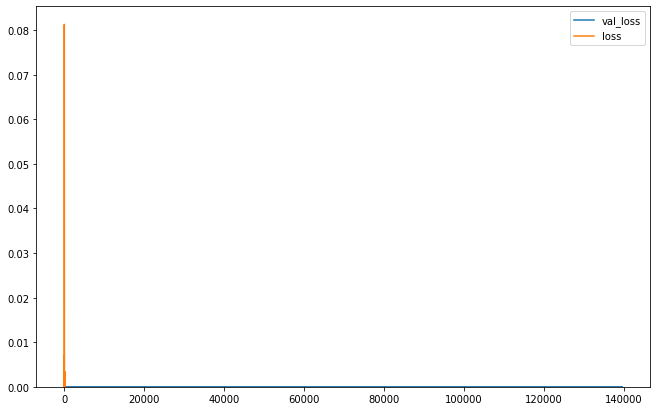

In [ ]:
plt.figure(figsize=(11,7))
sns.kdeplot(df['val_loss'])
sns.kdeplot(df['loss'])

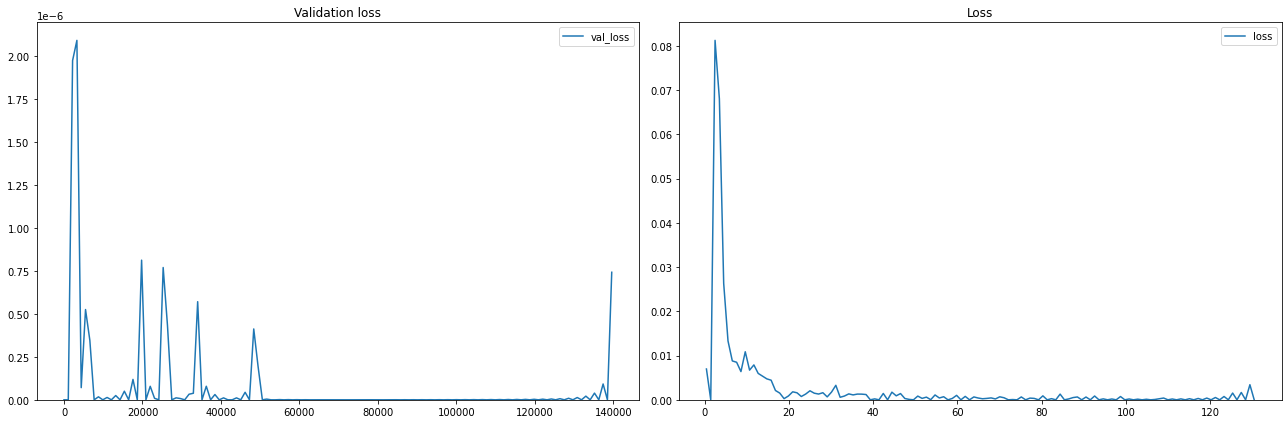

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Validation loss')
sns.kdeplot(df['val_loss'])
plt.subplot(1,2,2)
plt.title('Loss')
sns.kdeplot(df['loss'])
plt.tight_layout()

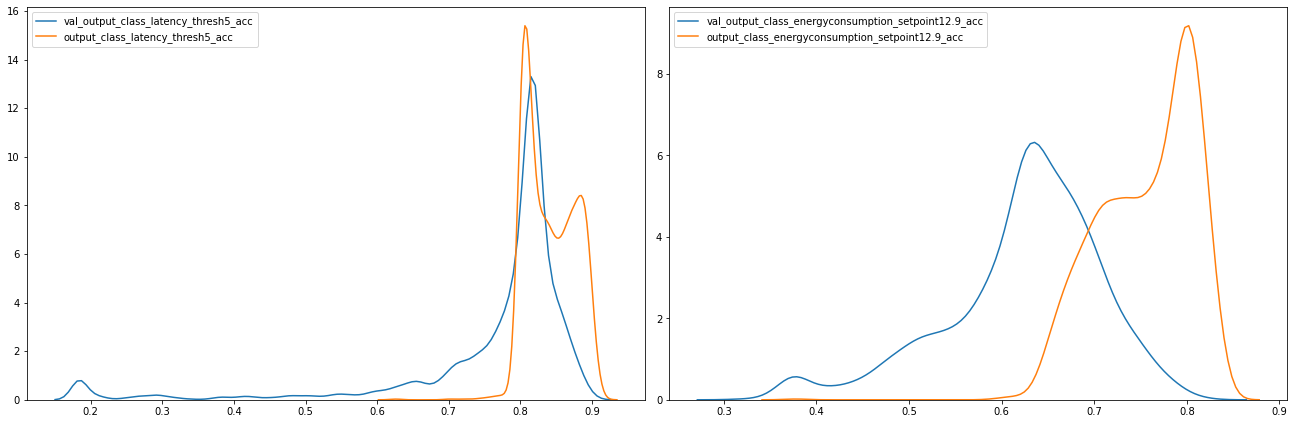

In [ ]:
plot_cols(acc_cols, df)

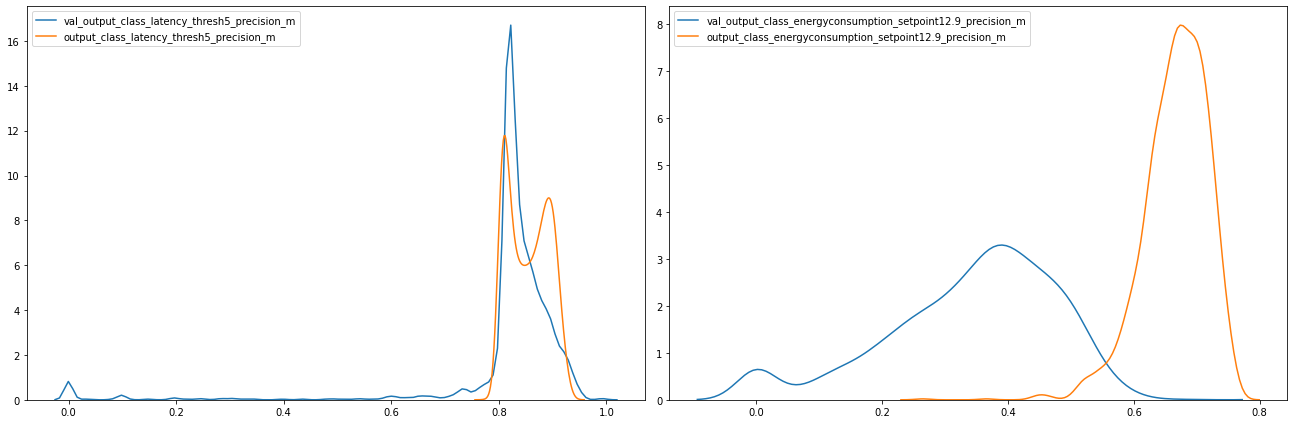

In [ ]:
plot_cols(prec_cols, df)

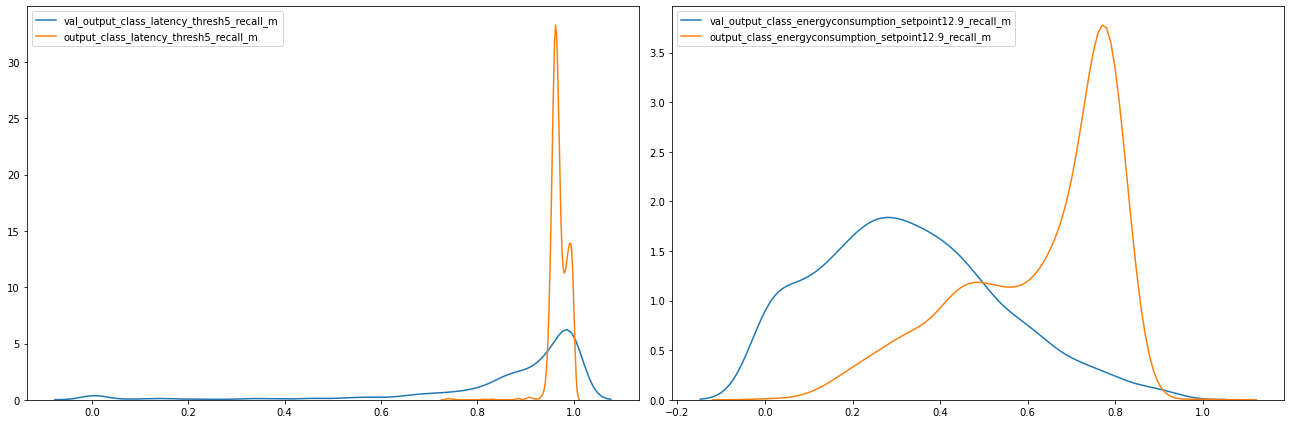

In [ ]:
plot_cols(rec_cols, df)

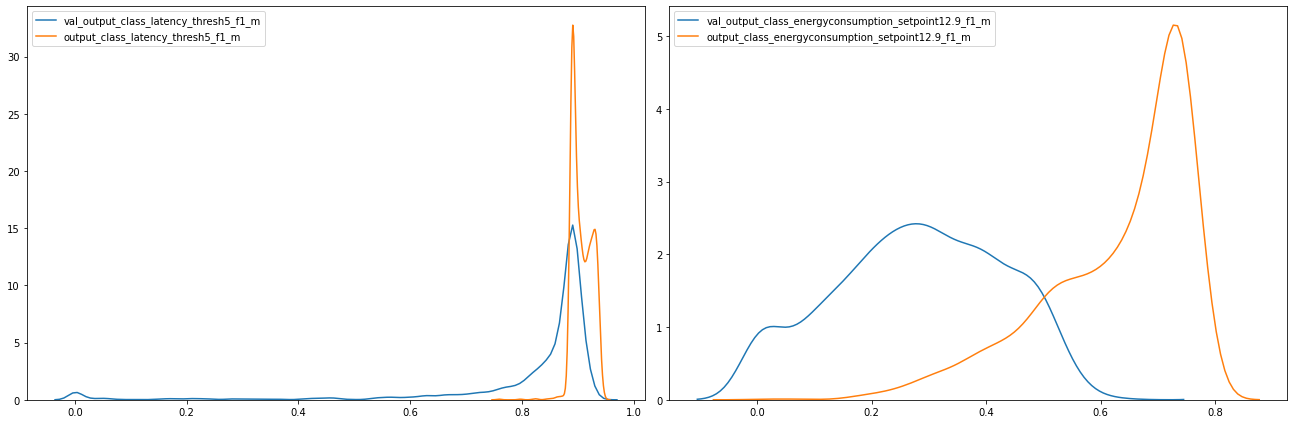

In [ ]:
plot_cols(f1_cols, df)

In [ ]:
df[df['val_loss'] == min(df['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
158,158,19,1.306159,0.71643,0.305886,0.42222,0.864969,0.902376,0.941518,0.878702,0.814815,0.503671,0.578548,0.47354,1.253704,0.712972,0.253252,0.373238,0.901296,0.939248,0.923019,0.957804,0.82463,0.757764,0.741648,0.784483,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
df.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
158,158,19,1.306159,0.716430,0.305886,0.422220,0.864969,0.902376,0.941518,0.878702,0.814815,0.503671,0.578548,0.473540,1.253704,0.712972,0.253252,0.373238,0.901296,0.939248,0.923019,0.957804,0.824630,0.757764,0.741648,0.784483,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
165,165,16,1.530801,0.837306,0.323888,0.510709,0.861883,0.909475,0.897811,0.934393,0.736883,0.506059,0.477242,0.591477,1.315770,0.733143,0.230210,0.378313,0.901667,0.939528,0.921894,0.959643,0.818333,0.753464,0.727593,0.793998,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
462,462,18,1.567635,0.859379,0.360617,0.518693,0.877315,0.917346,0.885250,0.970558,0.710648,0.525442,0.484324,0.657236,1.387020,0.803976,0.247003,0.378956,0.898148,0.937200,0.922259,0.954583,0.821296,0.758131,0.726783,0.804078,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
450,450,17,1.572171,0.875429,0.355850,0.486645,0.859568,0.908154,0.881349,0.956221,0.758488,0.426931,0.531590,0.390952,1.399674,0.795924,0.272558,0.382485,0.892778,0.934827,0.906210,0.967382,0.818704,0.754449,0.722102,0.802067,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
598,598,23,1.588648,0.759199,0.354235,0.846967,0.851080,0.880420,0.953631,0.849838,0.704475,0.270042,0.402086,0.241979,1.288755,0.742440,0.252451,0.380399,0.894259,0.935034,0.916526,0.956222,0.813333,0.742946,0.730419,0.770946,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
758,758,14,1.715243,0.921354,0.492667,0.587131,0.795525,0.821999,0.903130,0.804341,0.728395,0.397231,0.461288,0.403244,1.468247,0.873218,0.288273,0.391567,0.880926,0.927998,0.897499,0.962605,0.814630,0.752978,0.717155,0.802904,64,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
738,738,16,1.716232,0.988926,0.340278,0.570695,0.876543,0.912183,0.923255,0.914020,0.765432,0.427293,0.507023,0.412373,1.453798,0.861823,0.250016,0.389061,0.899074,0.938290,0.916034,0.963511,0.808889,0.744052,0.715057,0.788997,64,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
190,190,12,1.718786,0.905998,0.387630,0.767525,0.839506,0.869731,0.944115,0.833943,0.745370,0.284584,0.520866,0.221100,1.496786,0.922080,0.276831,0.399225,0.895556,0.936922,0.904904,0.972791,0.808704,0.740988,0.720071,0.776744,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler

#### Check other metrics

Accuracy

In [ ]:
print(acc_cols)

['val_output_class_latency_thresh5_acc', 'val_output_class_energyconsumption_setpoint12.9_acc', 'output_class_latency_thresh5_acc', 'output_class_energyconsumption_setpoint12.9_acc']


In [ ]:
df[df['val_output_class_latency_thresh5_acc'] == min(df['val_output_class_latency_thresh5_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
72,72,9,19.654448,16.977234,3.070040,1.828106,0.18287,0.000000,0.000000,0.000000,0.625772,0.000000,0.000000,0.000000,2.597896,1.932680,0.375707,0.494424,0.840741,0.905630,0.858357,0.960869,0.734815,0.639966,0.622740,0.669707,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
96,96,5,800.361841,793.599051,11.091823,1.880427,0.18287,0.012744,0.032922,0.007901,0.553241,0.024079,0.049383,0.018018,5.981970,5.163758,0.491736,0.595087,0.812407,0.891154,0.829672,0.964442,0.684444,0.417003,0.619919,0.323797,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
128,128,12,3459.213964,3449.388262,13.170573,5.948082,0.18287,0.000000,0.000000,0.000000,0.625772,0.000000,0.000000,0.000000,27.137803,26.379847,0.411245,0.572929,0.832407,0.901758,0.847626,0.965432,0.690926,0.488257,0.595249,0.422290,64,"[20, 10, 5]","[50, 25, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
188,188,4,164.435892,152.651777,13.170573,9.862524,0.18287,0.000000,0.000000,0.000000,0.374228,0.482739,0.374228,0.802469,2.443852,1.737222,0.354474,0.508379,0.865556,0.919886,0.877061,0.969129,0.720741,0.564234,0.641811,0.519666,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
224,224,13,38.549578,36.522038,1.216696,2.270851,0.18287,0.000000,0.000000,0.000000,0.625772,0.000000,0.000000,0.000000,1.779904,1.090205,0.337010,0.470700,0.864259,0.918810,0.880884,0.961850,0.767222,0.679455,0.667088,0.702402,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
360,360,10,187.294615,180.724218,10.647951,2.019873,0.18287,0.000000,0.000000,0.000000,0.375000,0.482141,0.374506,0.798011,2.145515,1.494888,0.342605,0.480889,0.867593,0.920159,0.884094,0.962460,0.752778,0.654890,0.656963,0.665669,64,"[30, 10, 4]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
368,368,9,2251.741226,2243.305152,11.889270,4.434108,0.18287,0.000000,0.000000,0.000000,0.374228,0.482739,0.374228,0.802469,2.319420,1.569187,0.407114,0.536802,0.830000,0.900931,0.842367,0.971067,0.703889,0.550841,0.602883,0.515504,64,"[30, 10, 4]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
376,376,6,59.563427,56.586410,4.576542,0.765098,0.18287,0.000000,0.000000,0.000000,0.662037,0.203914,0.201531,0.242976,3.421251,2.664096,0.327978,0.571793,0.877037,0.926049,0.890127,0.966995,0.681481,0.463672,0.585810,0.393962,64,"[30, 10, 4]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__

In [ ]:
df[df['val_output_class_energyconsumption_setpoint12.9_acc'] == min(df['val_output_class_energyconsumption_setpoint12.9_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
1633,1633,4,262.993753,261.883503,0.539199,0.912493,0.81713,0.892647,0.81713,1.0,0.320988,0.366289,0.331027,0.554659,3.065537,2.197754,0.435698,0.524476,0.804444,0.890622,0.806489,0.995413,0.700185,0.531461,0.606823,0.477528,128,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)


In [ ]:
df.sort_values('val_output_class_latency_thresh5_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
1163,1163,13,20.319514,19.614920,0.321652,0.527563,0.898920,0.935002,0.896475,0.983299,0.732253,0.487020,0.577357,0.483246,1.526552,0.896160,0.299258,0.403053,0.883519,0.929983,0.896949,0.966621,0.797593,0.739751,0.683981,0.812473,128,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
52,52,15,1.945947,1.324726,0.250672,0.453043,0.898148,0.930230,0.902731,0.965719,0.783951,0.519205,0.548536,0.524513,1.465844,0.880533,0.233455,0.395570,0.899630,0.938299,0.922301,0.956638,0.813704,0.747915,0.721555,0.787884,64,"[20, 10, 5]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
615,615,25,2.741697,2.046978,0.308008,0.633780,0.896605,0.926119,0.927909,0.935374,0.663580,0.470679,0.489419,0.545603,1.220722,0.683309,0.255528,0.370640,0.892407,0.934006,0.913348,0.957907,0.827222,0.761501,0.745700,0.786222,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
729,729,13,2.762806,2.044565,0.259965,0.713099,0.896605,0.925128,0.915944,0.941544,0.614969,0.407587,0.399101,0.500158,1.487015,0.933535,0.235903,0.406561,0.897222,0.936699,0.919731,0.956139,0.814630,0.748695,0.725386,0.788664,64,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
880,880,17,4.630935,3.982108,0.307240,0.458718,0.895833,0.929157,0.908870,0.954419,0.763889,0.600731,0.569096,0.725228,1.293056,0.723869,0.218844,0.384475,0.906481,0.942628,0.926250,0.960410,0.805926,0.756579,0.686360,0.847799,128,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
6,6,11,3.484815,2.786838,0.322111,0.523412,0.891975,0.920008,0.930520,0.919957,0.718364,0.378273,0.492991,0.376889,1.939579,1.312780,0.297573,0.412523,0.885000,0.930205,0.898461,0.966311,0.799074,0.736146,0.693582,0.801182,64,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
295,295,9,5.801727,4.947899,0.372117,0.630383,0.891204,0.926003,0.907411,0.958911,0.690586,0.466599,0.539715,0.473703,2.077362,1.381837,0.308477,0.399424,0.879074,0.927080,0.891790,0.967032,0.814259,0.747147,0.728650,0.777305,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
294,294,6,8.850537,8.042706,0.304383,0.788663,0.890432,0.928791,0.881325,0.986680,0.651235,0.069664,0.224966,0.045890,2.097908,1.473393,0.307780,0.424077,0.874259,0.923695,0.892659,0.959632,0.790185,0.719711,0.690847,0.763809,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=Tru

In [ ]:
df.sort_values('val_output_class_energyconsumption_setpoint12.9_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
158,158,19,1.306159,0.716430,0.305886,0.422220,0.864969,0.902376,0.941518,0.878702,0.814815,0.503671,0.578548,0.473540,1.253704,0.712972,0.253252,0.373238,0.901296,0.939248,0.923019,0.957804,0.824630,0.757764,0.741648,0.784483,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1020,1020,9,15.510025,14.769565,0.493619,0.407296,0.818673,0.869092,0.936214,0.820475,0.810185,0.640388,0.579635,0.750237,1.444330,0.813196,0.277544,0.399416,0.893148,0.935607,0.905683,0.968602,0.802593,0.746264,0.689148,0.823406,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
463,463,24,3.479477,2.746302,0.467558,0.453541,0.826389,0.879566,0.875350,0.919974,0.808642,0.545878,0.528892,0.625342,1.278222,0.696808,0.248966,0.367140,0.891667,0.934377,0.905283,0.967323,0.826296,0.769031,0.736083,0.814812,64,"[30, 10, 4]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
306,306,15,1.877601,1.246330,0.335271,0.444457,0.868056,0.914674,0.875870,0.978127,0.793210,0.479893,0.530853,0.484666,1.291228,0.723657,0.270318,0.378443,0.891852,0.934663,0.902302,0.971123,0.822222,0.760497,0.731285,0.801769,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
746,746,15,2.599888,1.930753,0.404006,0.446554,0.828704,0.875457,0.940289,0.831568,0.792438,0.495441,0.573169,0.464803,1.343568,0.777520,0.254860,0.386238,0.888333,0.932288,0.903347,0.964783,0.815370,0.751244,0.724584,0.796435,64,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
878,878,17,3.587148,2.943120,0.391739,0.464751,0.831790,0.895037,0.862711,0.952363,0.790895,0.434718,0.507753,0.430937,1.362569,0.798813,0.303868,0.391430,0.875741,0.925415,0.891012,0.963678,0.812037,0.748145,0.720406,0.784319,128,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
310,310,13,2.434622,1.720751,0.433368,0.486946,0.819444,0.866663,0.915713,0.846163,0.789352,0.473501,0.556725,0.440807,1.444828,0.832420,0.317135,0.399604,0.879259,0.927182,0.892523,0.966894,0.805926,0.738492,0.711136,0.781969,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
594,594,10,2.109794,1.444694,0.374714,0.446987,0.873457,0.917118,0.878283,0.976938,0.787809,0.472903,0.498646,0.487585,1.416043,0.803238,0.306747,0.406381,0.870741,0.922299,0.887325,0.962575,0.799630,0.738199,0.694074,0.801701,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScale

F1-score

In [ ]:
print(f1_cols)

['val_output_class_latency_thresh5_f1_m', 'val_output_class_energyconsumption_setpoint12.9_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_energyconsumption_setpoint12.9_f1_m']


In [ ]:
df[df['val_output_class_latency_thresh5_f1_m'] == min(df['val_output_class_latency_thresh5_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
72,72,9,19.654448,16.977234,3.070040,1.828106,0.18287,0.0,0.0,0.0,0.625772,0.000000,0.000000,0.000000,2.597896,1.932680,0.375707,0.494424,0.840741,0.905630,0.858357,0.960869,0.734815,0.639966,0.622740,0.669707,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
128,128,12,3459.213964,3449.388262,13.170573,5.948082,0.18287,0.0,0.0,0.0,0.625772,0.000000,0.000000,0.000000,27.137803,26.379847,0.411245,0.572929,0.832407,0.901758,0.847626,0.965432,0.690926,0.488257,0.595249,0.422290,64,"[20, 10, 5]","[50, 25, 15]",30,0.0002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
188,188,4,164.435892,152.651777,13.170573,9.862524,0.18287,0.0,0.0,0.0,0.374228,0.482739,0.374228,0.802469,2.443852,1.737222,0.354474,0.508379,0.865556,0.919886,0.877061,0.969129,0.720741,0.564234,0.641811,0.519666,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
224,224,13,38.549578,36.522038,1.216696,2.270851,0.18287,0.0,0.0,0.0,0.625772,0.000000,0.000000,0.000000,1.779904,1.090205,0.337010,0.470700,0.864259,0.918810,0.880884,0.961850,0.767222,0.679455,0.667088,0.702402,64,"[20, 10, 5]","[50, 80, 35, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
360,360,10,187.294615,180.724218,10.647951,2.019873,0.18287,0.0,0.0,0.0,0.375000,0.482141,0.374506,0.798011,2.145515,1.494888,0.342605,0.480889,0.867593,0.920159,0.884094,0.962460,0.752778,0.654890,0.656963,0.665669,64,"[30, 10, 4]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
368,368,9,2251.741226,2243.305152,11.889270,4.434108,0.18287,0.0,0.0,0.0,0.374228,0.482739,0.374228,0.802469,2.319420,1.569187,0.407114,0.536802,0.830000,0.900931,0.842367,0.971067,0.703889,0.550841,0.602883,0.515504,64,"[30, 10, 4]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
376,376,6,59.563427,56.586410,4.576542,0.765098,0.18287,0.0,0.0,0.0,0.662037,0.203914,0.201531,0.242976,3.421251,2.664096,0.327978,0.571793,0.877037,0.926049,0.890127,0.966995,0.681481,0.463672,0.585810,0.393962,64,"[30, 10, 4]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
388,388,6,2884.937816,2879.982009,4.389335,4.863103,0.18287,0.0,0.0,0.0,0.625772,0.000000,0.000000,0.000000,3.971407,3.174436,0.384710,0.549048,0.846852,0.910110,0.855883,0.973818,0.681667,0.490003,0.575931,0.436638,64,"[30, 10, 4]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.Nadam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
436,436,4,15.628321,10.812312,6.085276,3.004360,0.18287,0.0,0.0,0.0,0.625772,

In [ ]:
df[df['val_output_class_energyconsumption_setpoint12.9_f1_m'] == min(df['val_output_class_energyconsumption_setpoint12.9_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,6,90.487744,87.551890,0.666408,4.807359,0.626543,0.678075,0.866818,0.586441,0.625772,0.0,0.0,0.0,1.768144,1.215150,0.277320,0.422101,0.884074,0.929930,0.898369,0.966125,0.791111,0.718418,0.693922,0.759554,64,"[20, 10, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
8,8,4,187.087690,181.257097,7.638950,3.549757,0.187500,0.010348,0.098765,0.005467,0.625772,0.0,0.0,0.0,2.155754,1.586949,0.252160,0.407119,0.889259,0.931754,0.917929,0.948107,0.802407,0.732740,0.711422,0.771528,64,"[20, 10, 5]","[50, 25, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
41,41,5,17.950813,15.327758,1.462564,3.360213,0.386574,0.366138,0.597291,0.286388,0.624228,0.0,0.0,0.0,1.702327,1.052747,0.372084,0.497004,0.853704,0.913219,0.866563,0.968012,0.745741,0.635270,0.652359,0.630883,64,"[20, 10, 5]","[50, 25, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
72,72,9,19.654448,16.977234,3.070040,1.828106,0.182870,0.000000,0.000000,0.000000,0.625772,0.0,0.0,0.0,2.597896,1.932680,0.375707,0.494424,0.840741,0.905630,0.858357,0.960869,0.734815,0.639966,0.622740,0.669707,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
80,80,7,68.968839,64.440494,5.850595,2.691031,0.185185,0.005051,0.098765,0.002594,0.625772,0.0,0.0,0.0,2.114371,1.357964,0.398030,0.596933,0.839630,0.905445,0.854773,0.964836,0.664444,0.344447,0.579910,0.250957,64,"[20, 10, 5]","[50, 25, 15]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,1588,6,14.125446,11.862144,1.769305,2.186623,0.550926,0.607577,0.948997,0.464083,0.625772,0.0,0.0,0.0,2.009799,1.373106,0.271546,0.419965,0.888889,0.932570,0.906217,0.961946,0.794444,0.723112,0.701763,0.755462,128,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
1592,1592,4,1984.187949,1982.363914,2.042879,1.026534,0.817130,0.892647,0.817130,1.000000,0.625772,0.0,0.0,0.0,2.000822,1.296594,0.379617,0.423644,0.838889,0.905125,0.855960,0.961493,0.787778,0.732192,0.668115,0.815758,128,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
1624,1624,4,34.413353,26.892104,8.288665,6.031849,0.190586,0.025488,0.084656,0.015002,0.625772,0.0,0.0,0.0,1.966758,1.209074,0.287798,0.483037,0.881111,0.928267,0.897504,0.962464,0.753889,0.647621,0.662092,0.639998,128,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"[30, 40, 1

In [ ]:
df.sort_values('val_output_class_latency_thresh5_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
1163,1163,13,20.319514,19.614920,0.321652,0.527563,0.898920,0.935002,0.896475,0.983299,0.732253,0.487020,0.577357,0.483246,1.526552,0.896160,0.299258,0.403053,0.883519,0.929983,0.896949,0.966621,0.797593,0.739751,0.683981,0.812473,128,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
52,52,15,1.945947,1.324726,0.250672,0.453043,0.898148,0.930230,0.902731,0.965719,0.783951,0.519205,0.548536,0.524513,1.465844,0.880533,0.233455,0.395570,0.899630,0.938299,0.922301,0.956638,0.813704,0.747915,0.721555,0.787884,64,"[20, 10, 5]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
880,880,17,4.630935,3.982108,0.307240,0.458718,0.895833,0.929157,0.908870,0.954419,0.763889,0.600731,0.569096,0.725228,1.293056,0.723869,0.218844,0.384475,0.906481,0.942628,0.926250,0.960410,0.805926,0.756579,0.686360,0.847799,128,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
294,294,6,8.850537,8.042706,0.304383,0.788663,0.890432,0.928791,0.881325,0.986680,0.651235,0.069664,0.224966,0.045890,2.097908,1.473393,0.307780,0.424077,0.874259,0.923695,0.892659,0.959632,0.790185,0.719711,0.690847,0.763809,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
615,615,25,2.741697,2.046978,0.308008,0.633780,0.896605,0.926119,0.927909,0.935374,0.663580,0.470679,0.489419,0.545603,1.220722,0.683309,0.255528,0.370640,0.892407,0.934006,0.913348,0.957907,0.827222,0.761501,0.745700,0.786222,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
295,295,9,5.801727,4.947899,0.372117,0.630383,0.891204,0.926003,0.907411,0.958911,0.690586,0.466599,0.539715,0.473703,2.077362,1.381837,0.308477,0.399424,0.879074,0.927080,0.891790,0.967032,0.814259,0.747147,0.728650,0.777305,64,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
729,729,13,2.762806,2.044565,0.259965,0.713099,0.896605,0.925128,0.915944,0.941544,0.614969,0.407587,0.399101,0.500158,1.487015,0.933535,0.235903,0.406561,0.897222,0.936699,0.919731,0.956139,0.814630,0.748695,0.725386,0.788664,64,"[40, 20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
583,583,13,4.437971,3.731344,0.308207,0.603852,0.887346,0.924963,0.898080,0.967306,0.744599,0.460838,0.525627,0.454357,1.450134,0.884178,0.244504,0.383985,0.898704,0.938003,0.917145,0.961556,0.823333,0.756147,0.746627,0.781878,64,"[40, 20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScale

In [ ]:
df.sort_values('val_output_class_energyconsumption_setpoint12.9_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint12.9_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint12.9_acc,val_output_class_energyconsumption_setpoint12.9_f1_m,val_output_class_energyconsumption_setpoint12.9_precision_m,val_output_class_energyconsumption_setpoint12.9_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint12.9_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint12.9_acc,output_class_energyconsumption_setpoint12.9_f1_m,output_class_energyconsumption_setpoint12.9_precision_m,output_class_energyconsumption_setpoint12.9_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
1020,1020,9,15.510025,14.769565,0.493619,0.407296,0.818673,0.869092,0.936214,0.820475,0.810185,0.640388,0.579635,0.750237,1.444330,0.813196,0.277544,0.399416,0.893148,0.935607,0.905683,0.968602,0.802593,0.746264,0.689148,0.823406,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
1056,1056,15,3.392172,2.687255,0.314883,0.511985,0.882716,0.921021,0.887603,0.958635,0.766975,0.600864,0.565214,0.715675,1.303394,0.699657,0.226674,0.394717,0.900185,0.939201,0.915228,0.965515,0.813519,0.745458,0.729615,0.766558,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
880,880,17,4.630935,3.982108,0.307240,0.458718,0.895833,0.929157,0.908870,0.954419,0.763889,0.600731,0.569096,0.725228,1.293056,0.723869,0.218844,0.384475,0.906481,0.942628,0.926250,0.960410,0.805926,0.756579,0.686360,0.847799,128,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
1068,1068,9,11.739155,11.010460,0.340491,0.511674,0.861111,0.903232,0.898751,0.912993,0.775463,0.600291,0.595651,0.661684,1.461000,0.807266,0.314711,0.383714,0.862222,0.917088,0.882173,0.956351,0.824074,0.766283,0.730697,0.812881,128,"[20, 10, 5]","[50, 80, 35, 15]",30,0.002,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]",<__main__.IDScaler object at 0x7f888c278f60>
916,916,15,3.186963,2.388783,0.527719,0.505435,0.822531,0.895047,0.821157,0.998683,0.729167,0.579455,0.477009,0.807245,1.424792,0.814310,0.279343,0.375144,0.888333,0.932717,0.901402,0.967224,0.829630,0.769656,0.746377,0.799604,128,"[20, 10, 5]","[50, 25, 15]",30,0.002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",<__main__.IDScaler object at 0x7f888c278f60>
1179,1179,23,9.484205,8.773171,0.480446,0.511409,0.780093,0.811230,0.898228,0.754739,0.738426,0.567324,0.523352,0.689860,1.212225,0.692991,0.255533,0.352137,0.896667,0.937154,0.911153,0.965644,0.835556,0.775968,0.759137,0.802092,128,"[30, 10, 4]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
869,869,8,11.832063,11.032915,0.575700,0.588801,0.821759,0.894995,0.821371,1.000000,0.665895,0.564380,0.492359,0.784179,1.890528,1.287581,0.367060,0.403843,0.831296,0.899249,0.861921,0.941982,0.805741,0.740006,0.713319,0.775813,128,"[20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
1467,1467,7,21.010360,20.199082,0.566906,0.532677,0.828704,0.893524,0.856285,0.951050,0.721451,0.560562,0.520577,0.697943,1.939337,1.293984,0.342040,0.422247,0.852407,0.912382,0.869227,0.961641,0.796296,0.723059,0.701705,0.753736,128,"[40, 20, 10, 5]","[50, 25, 15]",30,0.005,<class 'keras.optimizers.Nadam'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=Tr

# Online simulation - v1

In [ ]:
# The Holy trinity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.3)

### Prepare simulation data with verification times

In [ ]:
def get_verification_times(folder_path, cycle):
    df_adaptation_opts = load_data(os.path.join(folder_path, f'dataset_with_all_features{cycle}.json'))
    return df_adaptation_opts['verification_times'].to_list()

In [ ]:
# online learning configs
nb_tot_cycles = 300
df = construct_cycle_df(folder_path, cycle=3)
nb_opts = len(df)
del df

In [ ]:
data = []
for c in range(1,nb_tot_cycles):
    df = construct_cycle_df(folder_path, c)
    df['cycle'] = [c]*nb_opts
    df['verification_time'] = get_verification_times(folder_path, c)
    data.append(df)
df = pd.concat(data)
del data

In [ ]:
nb_links = len(df.env_link_dist.values[0])
df[['env_link{}_dist'.format(i) for i in range(nb_links)]] = pd.DataFrame(df.env_link_dist.values.tolist(), index= df.index)
df.drop(columns='env_link_dist', inplace=True)

nb_motes = len(df.env_mote_trafficload.values[0])
df[['env_mote{}_tl'.format(i) for i in range(nb_motes)]] = pd.DataFrame(df.env_mote_trafficload.values.tolist(), index= df.index)
df.drop(columns='env_mote_trafficload', inplace=True)

nb_links_snr = len(df.env_link_SNR.values[0])
df[['env_link{}_snr'.format(i) for i in range(nb_links_snr)]] = pd.DataFrame(df.env_link_SNR.values.tolist(), index= df.index)
df.drop(columns='env_link_SNR', inplace=True)

nb_links = len(df.env_link_power.values[0])
df[['env_link{}_power'.format(i) for i in range(nb_links)]] = pd.DataFrame(df.env_link_power.values.tolist(), index= df.index)
df.drop(columns='env_link_power', inplace=True)

In [ ]:
print(len(df))
df.head()

64584


,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,env_EC,env_PL,env_LA,cycle,verification_time,env_link0_dist,env_link1_dist,env_link2_dist,env_link3_dist,env_link4_dist,env_link5_dist,env_link6_dist,env_link7_dist,env_link8_dist,env_link9_dist,env_link10_dist,env_link11_dist,env_link12_dist,env_link13_dist,env_link14_dist,...,env_mote8_tl,env_mote9_tl,env_mote10_tl,env_mote11_tl,env_mote12_tl,env_mote13_tl,env_link0_snr,env_link1_snr,env_link2_snr,env_link3_snr,env_link4_snr,env_link5_snr,env_link6_snr,env_link7_snr,env_link8_snr,env_link9_snr,env_link10_snr,env_link11_snr,env_link12_snr,env_link13_snr,env_link14_snr,env_link15_snr,env_link16_snr,env_link0_power,env_link1_power,env_link2_power,env_link3_power,env_link4_power,env_link5_power,env_link6_power,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power
0,12.7298,7.513370,2.909090,100,100,100,100,100,0,100,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,144,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,0,50,50,27,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
1,12.7459,7.513370,0.763636,100,100,100,100,100,20,80,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,124,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,0,50,50,27,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
2,12.7596,6.869435,0.000000,100,100,100,100,100,40,60,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,0,50,50,27,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
3,12.7733,6.296525,0.000000,100,100,100,100,100,60,40,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,94,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,0,50,50,27,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
4,12.7870,6.072190,1.251060,100,100,100,100,100,80,20,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,88,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,0,50,50,27,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


## Setup1

In [ ]:
thresh = 0.5

In [ ]:
df_setup1 = pd.read_csv('df_setup1_online_with_exploration_v1.csv')
df_setup1.head()

,Unnamed: 0,cycle,pred_latency_thresh5,pred_packetloss_thresh10,pred_energyconsumption_opt,actual_pl,actual_la,actual_ec
0,0,1,0.884984,0.993682,12.404975,6.169025,6.81818,12.9070
1,1,1,0.952293,0.995339,12.409502,6.103530,3.25000,12.9536
2,2,1,0.976278,0.996742,12.419213,5.569695,0.40000,12.9983
3,3,1,0.974132,0.996961,12.421186,5.706035,0.00000,12.9115
4,4,1,0.966667,0.997069,12.428374,5.285080,0.00000,12.9306


### DNN model

**T1**: PL < 10%  
**T2**: LA < 5%  
**O1**: minimize EC

In [6]:
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
# Optimal params
params = {
    'core_layers': [50,25,15],
    'class_layers': [20,10,5],
    'reg_layers': [40,20,10,5],
    'scaler': StandardScaler(),
    'epochs': 30,
    'optimizer': Adam,
    'lr': 5e-3,
    'batch_size': 64
    }

In [8]:
from keras.optimizers import RMSprop
dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_layers'])
dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_layers'])
dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_layers'])
dlaser.add_optimizataion_goal('energyconsumption', Operator.Min, params['reg_layers'])
dlaser.compile(optimizer=params['optimizer'], lr=params['lr'])
dlaser.print_goals()
print('\n')
dlaser.print_model()

---------- THRESHOLD GOALS ----------
packetloss < 10
latency < 5
--------- OPTIMIZATION GOALS ---------
Minimize energyconsumption


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 85)           0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 50)           4300        main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 50)           200         dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 25)           1275

### Total reduction of all three goals

In [ ]:
nb_verifications = []
start_cycle = LEARNING_CYCLES + 1
nones = 0
setup_df = df_setup1
for c in range(start_cycle, max(setup_df.cycle)):
    cycle_df = setup_df[setup_df.cycle == c]

    cycle_idx = list(np.argsort(cycle_df['pred_energyconsumption_opt']))
    count = 0
    nb_count = 0
    valid = False
    while not valid and count < nb_opts:
        idx = cycle_idx[count]
        if all(cycle_df.iloc[[idx]]['pred_packetloss_thresh10'] > thresh) and all(cycle_df.iloc[[idx]]['pred_latency_thresh5'] > thresh):
            if all(cycle_df.iloc[[idx]]['actual_pl'] < 10) and all(cycle_df.iloc[[idx]]['actual_la'] < 5):
                valid = True
            nb_count += 1
        count +=1
    if not valid:
        nones += 1
    #else:
    nb_verifications.append(nb_count)

AASR

In [ ]:
print('AASR:')
reduction = np.sum((df_setup1['pred_packetloss_thresh10']>thresh)&(df_setup1['pred_latency_thresh5']>thresh))/len(df_setup1)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AASR:
0.6699905033238367
Amount that we retain:
0.33000949667616336


AANR

In [ ]:
print('AANR:')
reduction = np.sum(nb_verifications)/np.sum((df_setup1['pred_packetloss_thresh10']>thresh)&(df_setup1['pred_latency_thresh5']>thresh))
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AANR:
0.9455806783144912
Amount that we retain:
0.05441932168550873


Total reduction

In [ ]:
print('Total reduction:')
reduction = np.sum(nb_verifications)/len(df_setup1)# - nones_verified)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Total reduction:
0.982041107041107
Amount that we retain:
0.01795889295889296


In [ ]:
print('Nb nones:', nones)

Nb nones: 16


### Quality of total reduction

In [ ]:
setup_df = df_setup1

df['packetloss_pred'] = 0
df.loc[df.cycle > 
       + 1, 'packetloss_pred'] = setup_df['pred_packetloss_thresh10'] > thresh
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = setup_df['pred_latency_thresh5'] > thresh
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = setup_df['pred_energyconsumption_opt']

df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array((setup_df['pred_packetloss_thresh10'] > thresh) & (setup_df['pred_latency_thresh5'] > thresh)).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array((setup_df['actual_pl'] < 10) & (setup_df['actual_la'] < 5)).astype(bool)
df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,env_EC,env_PL,env_LA,cycle,verification_time,env_link0_dist,env_link1_dist,env_link2_dist,env_link3_dist,env_link4_dist,env_link5_dist,env_link6_dist,env_link7_dist,env_link8_dist,env_link9_dist,env_link10_dist,env_link11_dist,env_link12_dist,env_link13_dist,env_link14_dist,...,env_mote13_tl,env_link0_snr,env_link1_snr,env_link2_snr,env_link3_snr,env_link4_snr,env_link5_snr,env_link6_snr,env_link7_snr,env_link8_snr,env_link9_snr,env_link10_snr,env_link11_snr,env_link12_snr,env_link13_snr,env_link14_snr,env_link15_snr,env_link16_snr,env_link0_power,env_link1_power,env_link2_power,env_link3_power,env_link4_power,env_link5_power,env_link6_power,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,packetloss_pred,latency_pred,energyconsumption_pred,thresholds_pred,thresholds_goal
0,12.7298,7.513370,2.909090,100,100,100,100,100,0,100,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,144,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
1,12.7459,7.513370,0.763636,100,100,100,100,100,20,80,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,124,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
2,12.7596,6.869435,0.000000,100,100,100,100,100,40,60,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
3,12.7733,6.296525,0.000000,100,100,100,100,100,60,40,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,94,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
4,12.7870,6.072190,1.251060,100,100,100,100,100,80,20,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,88,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0


#### Visualize the prediction

In [ ]:
import seaborn as sns
def visualize_optimization(sub_df):
    sns.set(font_scale=1.3)  # crazy big
    plt.subplots(2,1, figsize=(13,12))

    pal = 'copper_r'

    plt.subplot(2,1,1)
    g = sns.scatterplot(x='packetloss', y='energyconsumption', data=sub_df, hue='energyconsumption_pred', s=85, legend=False, palette=pal)
    plt.plot([10, 10],[min(sub_df['energyconsumption']) - 0.05, max(sub_df['energyconsumption']) + 0.05], color='red', linewidth=3)
    plt.xlabel('Packet loss', fontsize=15)
    plt.ylabel('Energy consumption', fontsize=15)
    norm = plt.Normalize(min(sub_df['energyconsumption']), max(sub_df['energyconsumption']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.subplot(2,1,2)
    g = sns.scatterplot(x='latency', y='energyconsumption', data=sub_df, hue='energyconsumption_pred', s=85, legend=False, palette=pal)
    plt.plot([5, 5],[min(sub_df['energyconsumption']) - 0.05, max(sub_df['energyconsumption']) + 0.05], color='red', linewidth=3)
    plt.xlabel('Latency', fontsize=15)
    plt.ylabel('Energy consumption', fontsize=15)
    norm = plt.Normalize(min(sub_df['energyconsumption']), max(sub_df['energyconsumption']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.tight_layout()

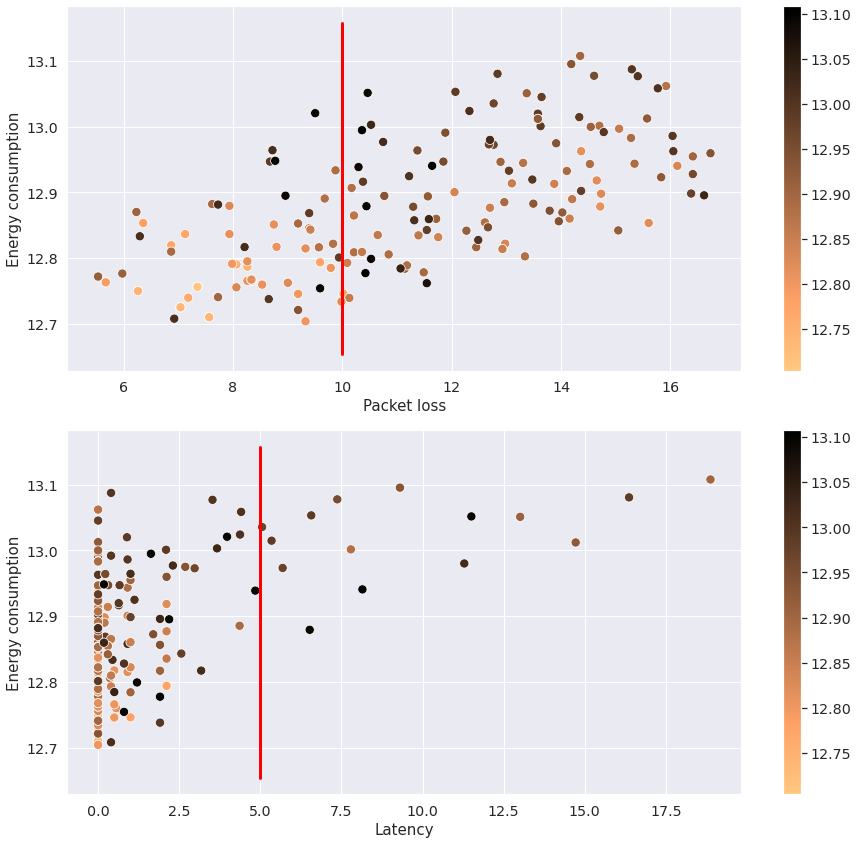

In [ ]:
cycle = 27
sub_df = df[df.cycle == nb_learnig_cycles + cycle]
visualize_optimization(sub_df)

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
reduced_verification_times = []
total_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    total_verification_times.append(np.sum(sub_df['verification_time']))
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    cycle_idx = list(np.argsort(sub_df['energyconsumption_pred']))
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
print(len(reduced_verification_times))
print(np.sum(reduced_verification_times))
reduced_time = np.sum(reduced_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000
print(reduced_time, 'seconds')
print((np.sum(total_verification_times) - np.sum(reduced_verification_times)) / (nb_tot_cycles - (nb_learnig_cycles + 2)) * 0.05 / 1000 + reduced_time, 'seconds')

1224
172933
0.6334542124542124 seconds
2.089542857142857 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 16


,EC_reduced,PL_reduced,LA_reduced
6,12.8305,6.897825,0.000000
20,13.0532,5.248465,0.757143
26,13.1041,4.499935,0.444444
6,12.7737,9.503455,4.762630
15,12.8700,9.810195,0.000000


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opts.append(best_opt)

In [ ]:
total_verification_times = df[(df.cycle >= nb_learnig_cycles + 2) & (df.cycle < nb_tot_cycles)]['verification_time']
print(len(total_verification_times))
print(np.sum(total_verification_times))
print(np.sum(total_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000, 'seconds')

58968
8123177
29.755227106227107 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 12


,EC_complete,PL_complete,LA_complete
6,12.8305,6.897825,0.00000
46,12.9608,7.155220,0.00000
0,12.7031,6.103530,1.00000
71,12.9870,8.034685,1.81818
36,12.8660,8.960050,4.30556


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete
6,12.8305,6.897825,0.000000,NaN,NaN,NaN
20,13.0532,5.248465,0.757143,NaN,NaN,NaN
26,13.1041,4.499935,0.444444,NaN,NaN,NaN
6,12.7737,9.503455,4.762630,NaN,NaN,NaN
15,12.8700,9.810195,0.000000,NaN,NaN,NaN


#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

12.7236816091954
12.77654435797666


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=10267.5, pvalue=6.482575131202232e-07)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=6686.5, pvalue=0.015798982569670588)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=9103.0, pvalue=5.875632121808623e-10)


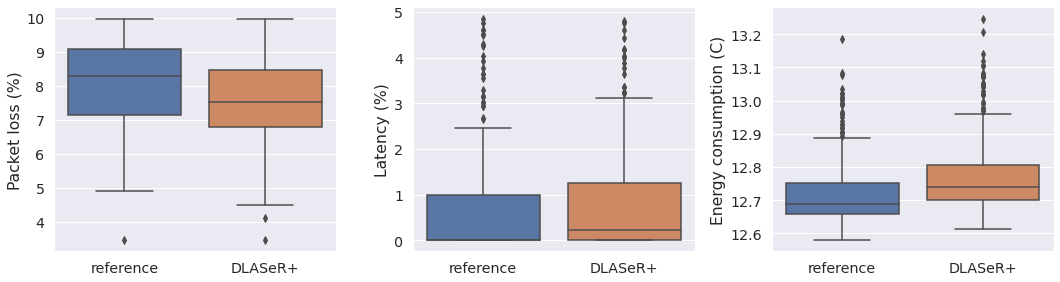

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(15,4.2))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR+' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR+' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR+' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

#### 2 THRESHOLD GOALS -> Compare quality with DLASeR and Quin F. et al.

**SELECT BEST ADAPT OPTION IN REDUCED SPACE BY USING 2 THRESHOLD GOALS**

In [ ]:
best_opt_reduced = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    sub_df = sub_df[sub_df.thresholds_goal == True] # Since all of the reduced options will be verified
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opt_reduced.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 16


,EC_reduced,PL_reduced,LA_reduced
6,12.8305,6.897825,0.000000
46,12.9608,7.155220,0.000000
26,13.1041,4.499935,0.444444
11,12.7238,9.854930,0.545455
4,12.8565,9.765155,0.000000


**LOAD DATA QUIN F. et al**

In [ ]:
# Data from Quin F. et al
import pandas as pd
quin_df = pd.read_csv('data_overall_results_v1.tsv', delimiter='\t')
print(len(quin_df))
quin_df.head()

300


,Optimal_PL,Optimal_LA,Optimal_EC,Optimal_T,Classification_PL,Classification_LA,Classification_EC,Classification_T,Regression_PL,Regression_LA,Regression_EC,Regression_T
0,8.818060,2.15909,12.8031,37.796,8.818060,2.15909,12.8031,37.799007,8.818060,2.15909,12.8031,37.798226
1,9.677980,0.00000,12.7196,37.412,9.677980,0.00000,12.7196,37.414905,9.677980,0.00000,12.7196,37.414100
2,9.167965,0.50000,12.7035,35.577,9.167965,0.50000,12.7035,35.580776,9.167965,0.50000,12.7035,35.579161
3,9.983245,1.11111,12.6605,35.895,9.983245,1.11111,12.6605,35.897828,9.983245,1.11111,12.6605,35.897416
4,8.722520,0.00000,12.6682,36.477,8.722520,0.00000,12.6682,36.480034,8.722520,0.00000,12.6682,36.479131


**LOAD DATA DLASER**

In [ ]:
dlaser_df = pd.read_csv('DLASeR_T1-T2_v1.csv')
dlaser_df = dlaser_df.rename(columns={col : 'dlaser_' + col for col in dlaser_df.columns })
dlaser_df.head()

,dlaser_Unnamed: 0,dlaser_EC_reduced,dlaser_PL_reduced,dlaser_LA_reduced
0,6,12.8305,6.897825,0.00000
1,46,12.9608,7.155220,0.00000
2,0,12.7031,6.103530,1.00000
3,71,12.9870,8.034685,1.81818
4,0,12.8717,7.753560,1.81818


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts, quin_df[['Classification_PL','Classification_LA','Classification_EC']], dlaser_df[['dlaser_PL_reduced', 'dlaser_LA_reduced', 'dlaser_EC_reduced']]])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete,Classification_PL,Classification_LA,Classification_EC,dlaser_PL_reduced,dlaser_LA_reduced,dlaser_EC_reduced
6,12.8305,6.897825,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,12.9608,7.155220,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,13.1041,4.499935,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.7238,9.854930,0.545455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12.8565,9.765155,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))
print(np.mean(dlaser_df['dlaser_EC_reduced']))
print(np.mean(quin_df['Optimal_EC']))
print(np.mean(combined_df['Classification_EC']))

12.7236816091954
12.729208560311285
12.726821343873516
12.724298000000001
12.730489000000006


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=14177.5, pvalue=0.06917159949489299)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=7066.5, pvalue=0.9602010606456997)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=15225.0, pvalue=0.3529957338840014)


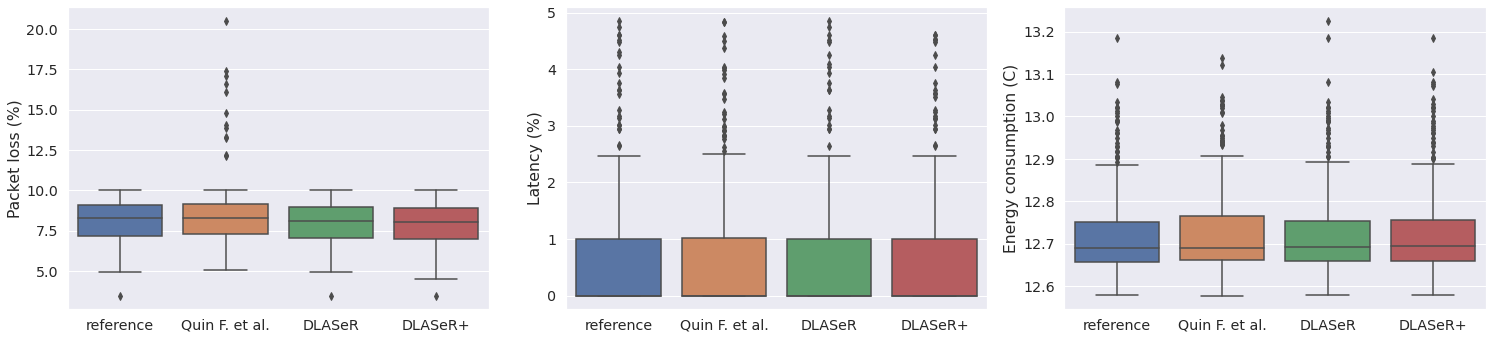

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(21,5))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'Classification_PL' : 'Quin F. et al.', 'dlaser_PL_reduced' : 'DLASeR', 'PL_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'Quin F. et al.', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'Quin F. et al.' : 'Classification_PL' , 'DLASeR' : 'dlaser_PL_reduced' ,'DLASeR+' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'Classification_LA' : 'Quin F. et al.',  'dlaser_LA_reduced' : 'DLASeR', 'LA_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'Quin F. et al.', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'Quin F. et al.' : 'Classification_LA', 'DLASeR' : 'dlaser_LA_reduced', 'DLASeR+' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'Classification_EC' : 'Quin F. et al.', 'dlaser_EC_reduced' : 'DLASeR', 'EC_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'Quin F. et al.', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'Quin F. et al.' : 'Classification_EC', 'DLASeR' : 'dlaser_EC_reduced', 'DLASeR+' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

#### 2 THRESHOLD GOALS & 1 OPTIMIZATION GOAL -> Compare quality with DLASeR and Quin F. et al.

**SELECT BEST ADAPT OPTION IN REDUCED SPACE BY USING 2 THRESHOLD GOALS AND 1 OPTIMIZATION GOAL**

In [ ]:
best_opt_reduced = []
reduced_verification_times = []
total_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    total_verification_times.append(np.sum(sub_df['verification_time']))
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    cycle_idx = list(np.argsort(sub_df['energyconsumption_pred']))
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)\

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 16


,EC_reduced,PL_reduced,LA_reduced
6,12.8305,6.897825,0.000000
20,13.0532,5.248465,0.757143
26,13.1041,4.499935,0.444444
6,12.7737,9.503455,4.762630
15,12.8700,9.810195,0.000000


**LOAD DATA DLASER**

In [ ]:
dlaser_df = pd.read_csv('DLASeR_TTO_v1.csv')
dlaser_df = dlaser_df.rename(columns={col : 'dlaser_' + col for col in dlaser_df.columns })
dlaser_df.head()

,dlaser_Unnamed: 0,dlaser_EC_reduced,dlaser_PL_reduced,dlaser_LA_reduced,dlaser_EC_complete,dlaser_PL_complete,dlaser_LA_complete
0,10,12.8305,6.897825,0.000000,NaN,NaN,NaN
1,20,13.0532,5.248465,0.757143,NaN,NaN,NaN
2,10,12.7347,6.753660,0.000000,NaN,NaN,NaN
3,15,13.0396,5.427085,1.590910,NaN,NaN,NaN
4,15,12.9979,8.212225,1.250000,NaN,NaN,NaN


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts, dlaser_df[['dlaser_PL_reduced', 'dlaser_LA_reduced', 'dlaser_EC_reduced']]])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete,dlaser_PL_reduced,dlaser_LA_reduced,dlaser_EC_reduced
6,12.8305,6.897825,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
20,13.0532,5.248465,0.757143,NaN,NaN,NaN,NaN,NaN,NaN
26,13.1041,4.499935,0.444444,NaN,NaN,NaN,NaN,NaN,NaN
6,12.7737,9.503455,4.762630,NaN,NaN,NaN,NaN,NaN,NaN
15,12.8700,9.810195,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))
print(np.mean(dlaser_df['dlaser_EC_reduced']))

12.7236816091954
12.77654435797666
12.767106719367591


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=10267.5, pvalue=6.482575131202232e-07)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=6686.5, pvalue=0.015798982569670588)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=9103.0, pvalue=5.875632121808623e-10)


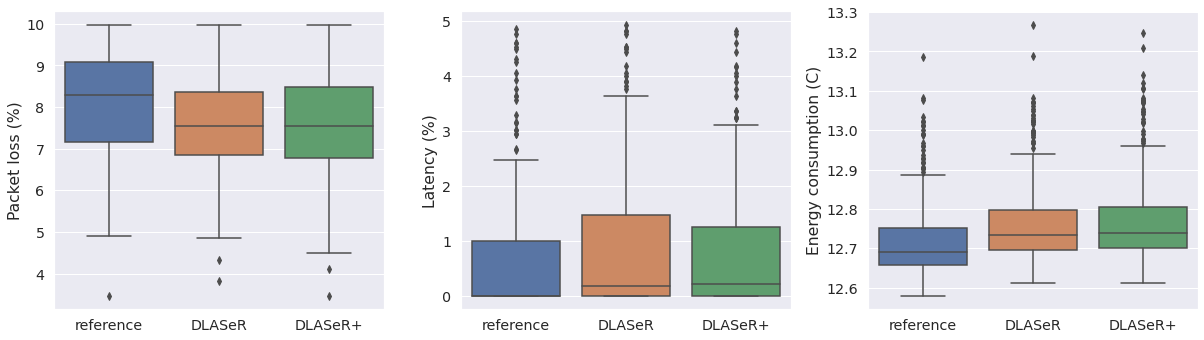

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(17,5))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'dlaser_PL_reduced' : 'DLASeR', 'PL_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'dlaser_PL_reduced' ,'DLASeR+' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference',  'dlaser_LA_reduced' : 'DLASeR', 'LA_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'dlaser_LA_reduced', 'DLASeR+' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'dlaser_EC_reduced' : 'DLASeR', 'EC_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'dlaser_EC_reduced', 'DLASeR+' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

## Setup 2

In [ ]:
thresh = 0.5

In [ ]:
df_setup2 = pd.read_csv('df_setup2_online_with_exploration_v1.csv')
df_setup2.head()

,Unnamed: 0,cycle,pred_latency_thresh5,pred_packetloss_thresh10,pred_energyconsumption_setpoint12.9,actual_pl,actual_la,actual_ec
0,0,1,0.989916,0.995969,0.747531,6.169025,6.81818,12.9070
1,1,1,0.979064,0.997445,0.807942,6.103530,3.25000,12.9536
2,2,1,0.930470,0.998177,0.828261,5.569695,0.40000,12.9983
3,3,1,0.756131,0.998604,0.747892,5.706035,0.00000,12.9115
4,4,1,0.504162,0.998855,0.408784,5.285080,0.00000,12.9306


### DNN model

**T1**: PL < 10%  
**T2**: LA < 5%  
**S1**: EC == 12.9 +/- 0.1

In [9]:
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
# Optimal params
params = {
    'core_layers': [50,25,15],
    'class_layers': [30,10,4],
    'scaler': StandardScaler(),
    'epochs': 30,
    'optimizer': Adam,
    'lr': 5e-3,
    'batch_size': 64
    }

In [10]:
dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_layers'])
dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_layers'])
dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_layers'])
dlaser.add_setpoint_goal('energyconsumption', 12.9, 0.1, params['class_layers'])
dlaser.compile(optimizer=params['optimizer'], lr=params['lr'])
dlaser.print_goals()
print('\n')
dlaser.print_model()

---------- THRESHOLD GOALS ----------
packetloss < 10
latency < 5
---------- SET-POINT GOALS ----------
energyconsumption == 12.9


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 85)           0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 50)           4300        main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 50)           200         dense_25[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 25)           1275 

**Reduction of both threshold goals**

In [ ]:
pred_combined_thresh = np.array((df_setup2['pred_packetloss_thresh10']>thresh) & (df_setup2['pred_latency_thresh5']>thresh)).astype(np.float16)
actual_combined_thresh = np.array((df_setup2['actual_pl'] < 10) & (df_setup2['actual_la']  < 5)).astype(np.float16)
prec = precision(actual_combined_thresh, pred_combined_thresh)
rec = recall(actual_combined_thresh, pred_combined_thresh)
print('Precision:', prec)
print('Recall:', rec)
print('F1:', f1(prec, rec))

Precision: 0.8517621884631448
Recall: 0.7427827961789165
F1: 0.7935483866805411


In [ ]:
print('Adaptation space reduction:')
print('Only PL:', 1 - np.sum(df_setup2['pred_packetloss_thresh10']>thresh)/len(df_setup2))
print('Only LA:', 1 - np.sum(df_setup2['pred_latency_thresh5']>thresh)/len(df_setup2))
reduction = np.sum((df_setup2['pred_packetloss_thresh10']>thresh)&(df_setup2['pred_latency_thresh5']>thresh)) / len(df_setup2)
print('Both:', 1 - reduction)
print('Amount that we retain:')
print(reduction)

Adaptation space reduction:
Only PL: 0.6867114367114366
Only LA: 0.14077126577126575
Both: 0.6987857821191155
Amount that we retain:
0.30121421788088454


**Reduction of set-point goal**

In [ ]:
print('Adaptation space reduction:')
print('Only EC:', 1 - np.sum(df_setup2['pred_energyconsumption_setpoint12.9']>thresh)/len(df_setup2))
print('Amount that we retain:')
print(np.sum(df_setup2['pred_energyconsumption_setpoint12.9']>thresh)/len(df_setup2))

Adaptation space reduction:
Only EC: 0.5236060236060236
Amount that we retain:
0.4763939763939764


### Total reduction of all three goals

In [ ]:
import random

nb_verifications = []
start_cycle = LEARNING_CYCLES + 1
nones = 0
setup_df = df_setup2
for c in range(start_cycle, max(setup_df.cycle)):
    cycle_df = setup_df[setup_df.cycle == c]

    cycle_idx = [i for i in range(nb_opts)]
    random.shuffle(cycle_idx)
    count = 0
    nb_count = 0
    valid = False
    while not valid and count < nb_opts:
        idx = cycle_idx[count]
        if all(cycle_df.iloc[[idx]]['pred_packetloss_thresh10'] > thresh) and all(cycle_df.iloc[[idx]]['pred_latency_thresh5'] > thresh) and all(cycle_df.iloc[[idx]]['pred_energyconsumption_setpoint12.9'] > thresh):
            if all(cycle_df.iloc[[idx]]['actual_pl'] < 10) and all(cycle_df.iloc[[idx]]['actual_la'] < 5) and all(cycle_df.iloc[[idx]]['actual_ec'] < 13) and all(cycle_df.iloc[[idx]]['actual_ec'] > 12.8) :
                valid = True
            nb_count += 1
        count +=1
    if not valid:
        nones += 1
    #else:
    nb_verifications.append(nb_count)

AASR

In [ ]:
print('AASR:')
reduction = np.sum((df_setup2['pred_packetloss_thresh10']>thresh)&(df_setup2['pred_latency_thresh5']>thresh)&(df_setup2['pred_energyconsumption_setpoint12.9']>thresh)) / len(df_setup2)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AASR:
0.8784934201600868
Amount that we retain:
0.12150657983991317


AANR

In [ ]:
print('AANR:')
reduction = np.sum(nb_verifications)/np.sum((df_setup2['pred_packetloss_thresh10']>thresh)&(df_setup2['pred_latency_thresh5']>thresh)&(df_setup2['pred_energyconsumption_setpoint12.9']>thresh))
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AANR:
0.8650383810188416
Amount that we retain:
0.1349616189811584


Total reduction

In [ ]:
print('Total reduction:')
reduction = np.sum(nb_verifications)/len(df_setup2)# - nones_verified)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Total reduction:
0.9836012752679419
Amount that we retain:
0.016398724732058067


In [ ]:
print('Nb nones:', nones)

Nb nones: 57


### Quality of total reduction

In [ ]:
setup_df = df_setup2

df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = setup_df['pred_packetloss_thresh10'] > thresh
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = setup_df['pred_latency_thresh5'] > thresh
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = setup_df['pred_energyconsumption_setpoint12.9']

df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array((setup_df['pred_packetloss_thresh10'] > thresh) & (setup_df['pred_latency_thresh5'] > thresh)).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array((setup_df['actual_pl'] < 10) & (setup_df['actual_la'] < 5)).astype(bool)
df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,env_EC,env_PL,env_LA,cycle,verification_time,env_link0_dist,env_link1_dist,env_link2_dist,env_link3_dist,env_link4_dist,env_link5_dist,env_link6_dist,env_link7_dist,env_link8_dist,env_link9_dist,env_link10_dist,env_link11_dist,env_link12_dist,env_link13_dist,env_link14_dist,...,env_mote13_tl,env_link0_snr,env_link1_snr,env_link2_snr,env_link3_snr,env_link4_snr,env_link5_snr,env_link6_snr,env_link7_snr,env_link8_snr,env_link9_snr,env_link10_snr,env_link11_snr,env_link12_snr,env_link13_snr,env_link14_snr,env_link15_snr,env_link16_snr,env_link0_power,env_link1_power,env_link2_power,env_link3_power,env_link4_power,env_link5_power,env_link6_power,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,packetloss_pred,latency_pred,energyconsumption_pred,thresholds_pred,thresholds_goal
0,12.7298,7.513370,2.909090,100,100,100,100,100,0,100,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,144,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
1,12.7459,7.513370,0.763636,100,100,100,100,100,20,80,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,124,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
2,12.7596,6.869435,0.000000,100,100,100,100,100,40,60,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
3,12.7733,6.296525,0.000000,100,100,100,100,100,60,40,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,94,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
4,12.7870,6.072190,1.251060,100,100,100,100,100,80,20,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,88,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0


#### Visualize the prediction

[]

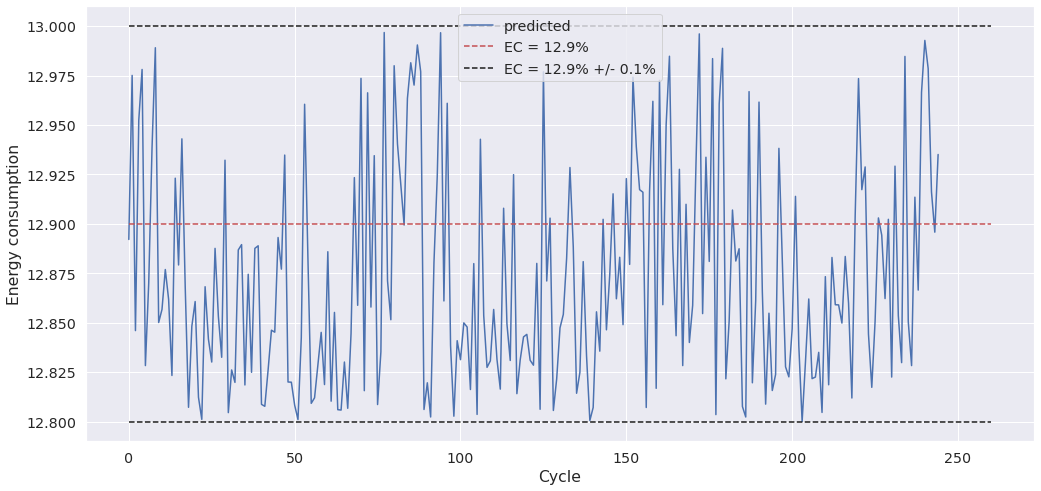

In [ ]:
setup_df = df_setup2

plt.figure(figsize=(17,8))
plt.plot(df_best_opt_reduced['EC_reduced'].values, label='predicted')
plt.plot([0,260],[12.9, 12.9], 'r--', label='EC = 12.9%')
plt.plot([0,260],[13, 13], 'k--', label='EC = 12.9% +/- 0.1%')
plt.plot([0,260],[12.8, 12.8], 'k--')
plt.ylabel('Energy consumption')
plt.xlabel('Cycle')
plt.legend()
plt.plot()

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
reduced_verification_times = []
total_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    total_verification_times.append(np.sum(sub_df['verification_time']))
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction

    cycle_idx = [i for i in range(len(sub_df))]
    random.shuffle(cycle_idx)
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5) and all(sub_df.iloc[[idx]]['energyconsumption'] <= 13) and all(sub_df.iloc[[idx]]['energyconsumption'] >= 12.8):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
print(len(reduced_verification_times))
print(np.sum(reduced_verification_times))
reduced_time = np.sum(reduced_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000
print(reduced_time, 'seconds')
print((np.sum(total_verification_times) - np.sum(reduced_verification_times)) / (nb_tot_cycles - (nb_learnig_cycles + 2)) * 0.05 / 1000 + reduced_time, 'seconds')

2169
273080
1.0002930402930403 seconds
2.4380397435897434 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 28


,EC_reduced,PL_reduced,LA_reduced
76,12.8921,8.009865,3.020200
1,12.9751,5.248465,2.531570
34,12.8460,4.982320,0.000000
35,12.9524,4.328620,0.909091
57,12.9781,9.702865,0.500000


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    count = 0
    cycle_idx = [i for i in range(len(sub_df))]
    random.shuffle(cycle_idx)
    valid = False
    while not valid and count < len(sub_df):
        idx = cycle_idx[count]
        if (sub_df.iloc[idx]['energyconsumption'] < 13 and sub_df.iloc[idx]['energyconsumption'] > 12.8):
            valid = True
            best_opt = sub_df.iloc[idx]#[abs(sub_df.energyconsumption - 67) == min(abs(sub_df.energyconsumption - 67))].iloc[0]
        count += 1
    best_opts.append(best_opt)

In [ ]:
total_verification_times = df[(df.cycle >= nb_learnig_cycles + 2) & (df.cycle < nb_tot_cycles)]['verification_time']
print(len(total_verification_times))
print(np.sum(total_verification_times))
print(np.sum(total_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000, 'seconds')

58968
8123177
29.755227106227107 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 21


,EC_complete,PL_complete,LA_complete
36,12.9727,8.263395,1.250000
46,12.9608,7.155220,0.000000
188,12.9267,9.459950,0.222222
1,12.9947,5.173835,4.230500
0,12.8717,7.753560,1.818180


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete
76,12.8921,8.009865,3.020200,NaN,NaN,NaN
1,12.9751,5.248465,2.531570,NaN,NaN,NaN
34,12.8460,4.982320,0.000000,NaN,NaN,NaN
35,12.9524,4.328620,0.909091,NaN,NaN,NaN
57,12.9781,9.702865,0.500000,NaN,NaN,NaN


#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

12.878471428571428
12.872900000000017


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=10526.0, pvalue=4.31542528692916e-05)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=5666.0, pvalue=0.5865078091515437)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=14154.0, pvalue=0.4735463654690163)


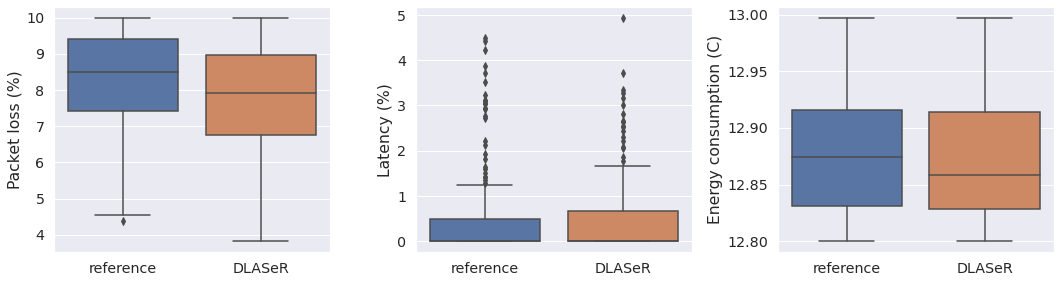

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(15,4.2))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

## Setup 3

In [ ]:
thresh = 0.5

In [ ]:
df_setup3 = pd.read_csv('df_setup3_online_with_exploration_v1.csv')
df_setup3.head()

,Unnamed: 0,cycle,pred_packetloss_opt,pred_latency_thresh5,pred_energyconsumption_setpoint12.9,actual_pl,actual_la,actual_ec
0,0,1,8.625283,0.825526,0.001538,6.169025,6.81818,12.9070
1,1,1,7.895401,0.917927,0.000562,6.103530,3.25000,12.9536
2,2,1,7.107277,0.962787,0.000269,5.569695,0.40000,12.9983
3,3,1,6.718706,0.980918,0.000328,5.706035,0.00000,12.9115
4,4,1,6.761883,0.978655,0.001362,5.285080,0.00000,12.9306


### DNN model

**T1**: LA < 5%  
**S1**: minimize PL  
**O1**: EC == 12.9 +/- 0.1

In [11]:
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
# Optimal params
params = {
    'core_layers': [50,80,35,15],
    'class_layers': [20,10,5],
    'reg_layers': [20,10,5],
    'scaler': MinMaxScaler(),
    'epochs': 30,
    'optimizer': Adam,
    'lr': 5e-3,
    'batch_size': 64
    }

In [12]:
dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_layers'])
dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_layers'])
dlaser.add_optimizataion_goal('packetloss', Operator.Min, params['reg_layers'])
dlaser.add_setpoint_goal('energyconsumption', 12.9, 0.1, params['class_layers'])
dlaser.compile(optimizer=params['optimizer'], lr=params['lr'])
dlaser.print_goals()
print('\n')
dlaser.print_model()

---------- THRESHOLD GOALS ----------
latency < 5
---------- SET-POINT GOALS ----------
energyconsumption == 12.9
--------- OPTIMIZATION GOALS ---------
Minimize packetloss


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 85)           0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 50)           4300        main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 50)           200         dense_36[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense

### Total reduction of all three goals

In [ ]:
nb_verifications = []
start_cycle = LEARNING_CYCLES + 1
nones = 0
nones_verified = 0
setup_df = df_setup3
for c in range(start_cycle, max(setup_df.cycle)):
    cycle_df = setup_df[setup_df.cycle == c]
    cycle_df = cycle_df[(cycle_df.pred_latency_thresh5 > thresh) & (cycle_df['pred_energyconsumption_setpoint12.9'] > thresh)] # Threshold and setpoint reduction
    cycle_idx = list(np.argsort(cycle_df['pred_packetloss_opt']))
    count = 0
    nb_count = 0
    valid = False
    while not valid and count < len(cycle_idx):
        idx = cycle_idx[count]
        #if all(cycle_df.iloc[[idx]]['pred_latency_thresh5'] > thresh) and all(cycle_df.iloc[[idx]]['pred_energyconsumption_setpoint12.9'] > thresh):
        if all(cycle_df.iloc[[idx]]['actual_la'] < 5) and all(cycle_df.iloc[[idx]]['actual_ec'] <= 13) and all(cycle_df.iloc[[idx]]['actual_ec'] >= 12.8):
            valid = True
        count +=1
    if not valid:
        nones += 1
        nones_verified += count
    nb_verifications.append(count)

AASR

In [ ]:
print('AASR:')
reduction = np.sum((df_setup3['pred_latency_thresh5']>thresh)&(df_setup3['pred_energyconsumption_setpoint12.9']>thresh))/len(df_setup3)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AASR:
0.46404829738163067
Amount that we retain:
0.5359517026183693


AANR

In [ ]:
print('AANR:')
reduction = np.sum(nb_verifications)/np.sum((df_setup3['pred_latency_thresh5']>thresh)&(df_setup3['pred_energyconsumption_setpoint12.9']>thresh))
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AANR:
0.9480761928869763
Amount that we retain:
0.05192380711302367


Total reduction

In [ ]:
print('Total reduction:')
reduction = np.sum(nb_verifications)/len(df_setup3)# - nones_verified)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Total reduction:
0.9721713471713471
Amount that we retain:
0.02782865282865283


In [ ]:
print('Nb nones:', nones)

Nb nones: 25


### Quality of total reduction

In [ ]:
setup_df = df_setup3

df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = setup_df['pred_packetloss_opt']
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = setup_df['pred_latency_thresh5'] > thresh
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = setup_df['pred_energyconsumption_setpoint12.9']

df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array(setup_df['pred_latency_thresh5'] > thresh).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array(setup_df['actual_la'] < 5).astype(bool)

df['setpoints_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'setpoints_pred'] = np.array(setup_df['pred_energyconsumption_setpoint12.9'] > thresh).astype(bool)
df['setpoints_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'setpoints_goal'] = np.array((setup_df['actual_ec'] < 13) & (setup_df['actual_ec'] > 12.8)).astype(bool)

df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,env_EC,env_PL,env_LA,cycle,verification_time,env_link0_dist,env_link1_dist,env_link2_dist,env_link3_dist,env_link4_dist,env_link5_dist,env_link6_dist,env_link7_dist,env_link8_dist,env_link9_dist,env_link10_dist,env_link11_dist,env_link12_dist,env_link13_dist,env_link14_dist,...,env_link1_snr,env_link2_snr,env_link3_snr,env_link4_snr,env_link5_snr,env_link6_snr,env_link7_snr,env_link8_snr,env_link9_snr,env_link10_snr,env_link11_snr,env_link12_snr,env_link13_snr,env_link14_snr,env_link15_snr,env_link16_snr,env_link0_power,env_link1_power,env_link2_power,env_link3_power,env_link4_power,env_link5_power,env_link6_power,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,packetloss_pred,latency_pred,energyconsumption_pred,thresholds_pred,thresholds_goal,setpoints_pred,setpoints_goal
0,12.7298,7.513370,2.909090,100,100,100,100,100,0,100,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,144,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0
1,12.7459,7.513370,0.763636,100,100,100,100,100,20,80,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,124,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0
2,12.7596,6.869435,0.000000,100,100,100,100,100,40,60,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0
3,12.7733,6.296525,0.000000,100,100,100,100,100,60,40,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,94,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0
4,12.7870,6.072190,1.251060,100,100,100,100,100,80,20,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,88,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0


#### Visualize the prediction

In [ ]:
import seaborn as sns
def visualize_optimization(sub_df):
    sns.set(font_scale=1.3)  # crazy big
    plt.subplots(2,1, figsize=(13,12))

    pal = 'copper_r'

    plt.subplot(2,1,1)
    g = sns.scatterplot(x='latency', y='packetloss', data=sub_df, hue='packetloss_pred', s=85, legend=False, palette=pal)
    plt.plot([5, 5],[min(sub_df['packetloss']) - 0.45, max(sub_df['packetloss']) + 0.45], color='red', linewidth=3)
    plt.xlabel('Latency', fontsize=15)
    plt.ylabel('Packet loss', fontsize=15)
    norm = plt.Normalize(min(sub_df['packetloss']), max(sub_df['packetloss']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.subplot(2,1,2)
    g = sns.scatterplot(x='energyconsumption', y='packetloss', data=sub_df, hue='packetloss_pred', s=85, legend=False, palette=pal)
    plt.plot([12.8, 12.8],[min(sub_df['packetloss']) - 0.45, max(sub_df['packetloss']) + 0.45], color='red', linewidth=3)
    plt.plot([12.9, 12.9],[min(sub_df['packetloss']) - 0.45, max(sub_df['packetloss']) + 0.45], color='green', linewidth=3)
    plt.plot([13, 13],[min(sub_df['packetloss']) - 0.45, max(sub_df['packetloss']) + 0.45], color='red', linewidth=3)
    plt.xlabel('Energy consumption', fontsize=15)
    plt.ylabel('Packet loss', fontsize=15)
    norm = plt.Normalize(min(sub_df['packetloss']), max(sub_df['packetloss']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.tight_layout()

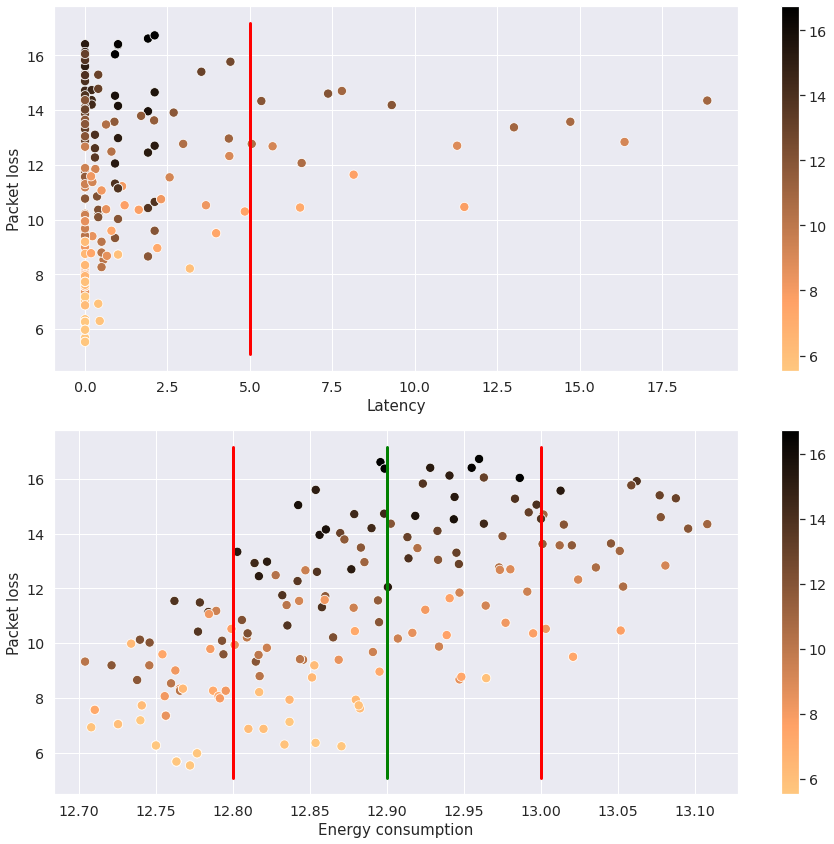

In [ ]:
cycle = 27 # 27
sub_df = df[df.cycle == nb_learnig_cycles + cycle]
visualize_optimization(sub_df)

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
reduced_verification_times = []
total_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    total_verification_times.append(np.sum(sub_df['verification_time']))
    sub_df = sub_df[(sub_df.thresholds_pred == True) & (sub_df.setpoints_pred == True)] # The reduced adaptation space by using prediction

    cycle_idx = list(np.argsort(sub_df['packetloss_pred'])) # [::-1] to make it descending
    best_opt = None
    count = 0
    valid = False
    while not valid and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['latency'] < 5) and all(sub_df.iloc[[idx]]['energyconsumption'] < 13) and all(sub_df.iloc[[idx]]['energyconsumption'] > 12.8):
            valid = True
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
print(len(reduced_verification_times))
print(np.sum(reduced_verification_times))
reduced_time = np.sum(reduced_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000
print(reduced_time, 'seconds')
print((np.sum(total_verification_times) - np.sum(reduced_verification_times)) / (nb_tot_cycles - (nb_learnig_cycles + 2)) * 0.05 / 1000 + reduced_time, 'seconds')

1804
204384
0.7486593406593406 seconds
2.1989877289377286 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 26


,EC_reduced,PL_reduced,LA_reduced
188,12.9267,9.45995,0.222222
154,12.9429,12.92800,0.000000
62,12.9862,11.26060,2.242340
61,12.9011,11.84770,0.000000
3,12.8438,10.50320,0.000000


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[(sub_df.thresholds_goal == True) & (sub_df.setpoints_goal == True)] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.packetloss == min(abs(sub_df.packetloss))].iloc[0]
    best_opts.append(best_opt)

In [ ]:
total_verification_times = df[(df.cycle >= nb_learnig_cycles + 2) & (df.cycle < nb_tot_cycles)]['verification_time']
print(len(total_verification_times))
print(np.sum(total_verification_times))
print(np.sum(total_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000, 'seconds')

58968
8123177
29.755227106227107 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 8


,EC_complete,PL_complete,LA_complete
5,12.9497,4.625400,0.000000
1,12.9751,5.248465,2.531570
5,12.8161,4.459125,0.000000
1,12.9947,5.173835,4.230500
31,12.9524,4.151780,0.181818


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete
188,12.9267,9.45995,0.222222,NaN,NaN,NaN
154,12.9429,12.92800,0.000000,NaN,NaN,NaN
62,12.9862,11.26060,2.242340,NaN,NaN,NaN
61,12.9011,11.84770,0.000000,NaN,NaN,NaN
3,12.8438,10.50320,0.000000,NaN,NaN,NaN


#### Compare quality

In [ ]:
nb_verifications = []
best_pred_options = []
start_cycle = LEARNING_CYCLES + 1
setup_df = df_setup3
for c in range(start_cycle, max(setup_df.cycle)):
    cycle_df = setup_df[setup_df.cycle == c]

    cycle_idx = list(np.argsort(cycle_df['pred_packetloss_opt']))
    count = 0
    valid = False
    best_pred_option = None
    while not valid and count < nb_opts:
        idx = cycle_idx[count]
        if all(cycle_df.iloc[[idx]]['actual_la'] < 5) and all(cycle_df.iloc[[idx]]['actual_ec'] <= 13) and all(cycle_df.iloc[[idx]]['actual_ec'] >= 12.8):
            valid = True
            best_pred_option = cycle_df.iloc[[idx]]
        count +=1
    nb_verifications.append(count)
    
    cycle_idx = list(np.argsort(cycle_df['actual_pl']))
    count = 0
    valid = False
    best_option = None
    while not valid and count < nb_opts:
        idx = cycle_idx[count]
        if all(cycle_df.iloc[[idx]]['actual_la'] < 5) and all(cycle_df.iloc[[idx]]['actual_ec'] <= 13) and all(cycle_df.iloc[[idx]]['actual_ec'] >= 12.8):
            valid = True
            best_option = cycle_df.iloc[[idx]]
        count += 1
    best_pred_options.append([best_pred_option, best_option])

In [ ]:
combined_df = pd.DataFrame(columns=['PL_reduced, LA_reduced, EC_reduced, PL_complete, LA_complete, EC_complete'])

In [ ]:
pl_reduced = []
la_reduced = []
ec_reduced = []
pl_complete = []
la_complete = []
ec_complete = []
for idx in range(np.array(best_pred_options).shape[0]):
    try:
        if np.array(best_pred_options)[idx,0] is not None:
            pl_reduced.append(np.array(best_pred_options)[idx,0]['actual_pl'].values[0])
            la_reduced.append(np.array(best_pred_options)[idx,0]['actual_la'].values[0])
            ec_reduced.append(np.array(best_pred_options)[idx,0]['actual_ec'].values[0])
            pl_complete.append(np.array(best_pred_options)[idx,1]['actual_pl'].values[0])
            la_complete.append(np.array(best_pred_options)[idx,1]['actual_la'].values[0])
            ec_complete.append(np.array(best_pred_options)[idx,1]['actual_ec'].values[0])
    except:
        pass

In [ ]:
print(len(pl_reduced))
print(len(pl_complete))

263
263


In [ ]:
combined_df = pd.DataFrame(columns=['PL_reduced, LA_reduced, EC_reduced, PL_complete, LA_complete, EC_complete'])
combined_df['PL_reduced'] = pl_reduced
combined_df['LA_reduced'] = la_reduced
combined_df['EC_reduced'] = ec_reduced
combined_df['PL_complete'] = pl_complete
combined_df['LA_complete'] = la_complete
combined_df['EC_complete'] = ec_complete

In [ ]:
print(np.mean(pl_complete))
print(np.mean(pl_reduced))

6.593075931558936
7.283631178707225


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(combined_df['PL_reduced'][:len(df_best_opt_reduced)], combined_df['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(combined_df['LA_reduced'][:len(df_best_opt_reduced)], combined_df['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(combined_df['EC_reduced'][:len(df_best_opt_reduced)], combined_df['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=0.0, pvalue=3.470276550057302e-27)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=1096.5, pvalue=0.08277481160840067)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=5656.5, pvalue=0.48765279500310177)


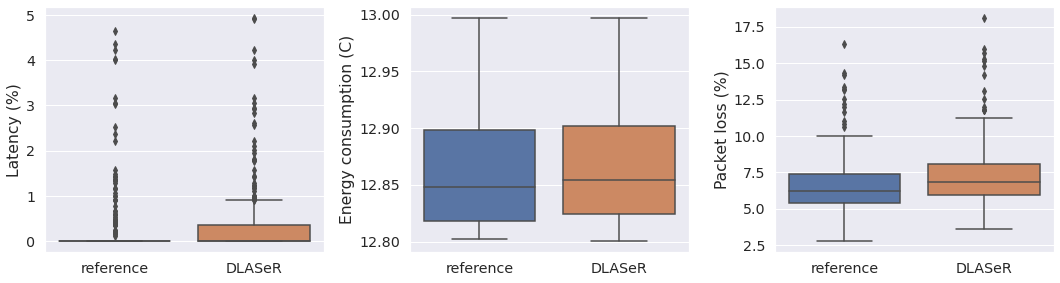

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(15,4.2))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.tight_layout()